# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle
import tensorflow as tf
import seaborn as sns
import scipy as sp

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features, select_features
from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings, EfficientFCParameters,MinimalFCParameters

from tqdm import tqdm

In [2]:
from utils.model_summary_functions import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting import plot_autocorrelation

In [3]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
plt.rcParams.update({
    'font.size': 18,
    'axes.linewidth':2,
    'axes.titlesize': 20,
    'lines.linewidth' : 1.5,
    'lines.markersize' : 10,
    'figure.figsize': (25,10),
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15,
    'font.family': 'Arial',
    'legend.fontsize':14,
    'axes.labelsize':20,
    'axes.grid':True,
})

In [5]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Importing Kuramoto dataset

We first import the solution obtained from the Kuramoto differential equation subject to periodic boundary conditions. The spatial domain has length L=200 and discretized with 512 nodes. The time step was 0.25 seconds with a time domain from t=0 to t=2000 seconds. 

$$ u_t + u_x u + u_{xx} + u_{xxxx}=0 \tag{1}$$ 


$$ u(t=0,x) = cos \frac{\pi x}{20}*(1+sin\frac{\pi x}{20})  \tag{2}$$


The first 500 seconds were truncated in order to avoid transients and model only the chaotic part of the solution

In [6]:
#X = np.load('Kuramoto_dataset\Kuramoto_X.npy')
#T = np.load('Kuramoto_dataset\Kuramoto_T.npy')
#U = np.load('Kuramoto_dataset\Kuramoto_U.npy')

X = np.linspace(0,200,512) # Discrete space domain vector
T = np.load('Kuramoto_dataset\KSTime.npy') # Discrete time domain vector
U = np.load('Kuramoto_dataset\KSSolution.npy') # Solution
X, T = np.meshgrid(X, T)

# Converting time to Lyapunov time

MLE = 0.094 # Maximal Lyapunov Time
T_lyapunov = T*MLE

print(X.shape)
print(T.shape)
print(U.shape)

(6000, 512)
(6000, 512)
(6000, 512)


In [7]:
#np.savetxt('data.csv', U, delimiter=',')

In [8]:
# fig, ax = plt.subplots(figsize=(14, 7))

# surf = ax.pcolor(X, T_lyapunov, U, cmap=plt.get_cmap("seismic"),shading='auto')

# plt.colorbar(surf)
# plt.xlabel('X')
# plt.ylabel('T $\Lambda_{max}$')
# plt.tight_layout()

## Creating the training and test set for evaluating PCA

The dataset has columns rows and 6000 rows. The first 90% will be used for training and the remaining 10% for testing. The time series sequence must be respected, so we cannot shuffle the data.

In [9]:
X_train = X[:5400]
T_train = T[:5400]
U_train = U[:5400]
X_test = X[5400:]
T_test = T[5400:]
U_test = U[5400:]

# X_train = X[:28000]
# T_train = T[:28000]
# U_train = U[:28000]

# X_test = X[28000:]
# T_test = T[28000:]
# U_test = U[28000:]

In [10]:
print(U_train.shape)
print(U_test.shape)
print('')
print(X_train.shape)
print(X_test.shape)
print('')
print(T_train.shape)
print(T_test.shape)

(5400, 512)
(600, 512)

(5400, 512)
(600, 512)

(5400, 512)
(600, 512)


In [11]:
# Normalizing the dataset to be with 0 mean and unit variance
scaler = StandardScaler()

U_scaled_train = scaler.fit_transform(U_train)
U_scaled_test = scaler.transform(U_test)

In [12]:
np.savetxt('U_scaled_train.csv', U_scaled_train, delimiter=',')

# Applying dimensionality reduction for the Kuramoto dataset - PCA

In [13]:
from utils import dim_reduction

## Threshold based on energy criteria

PCA model: PCA(n_components=92)


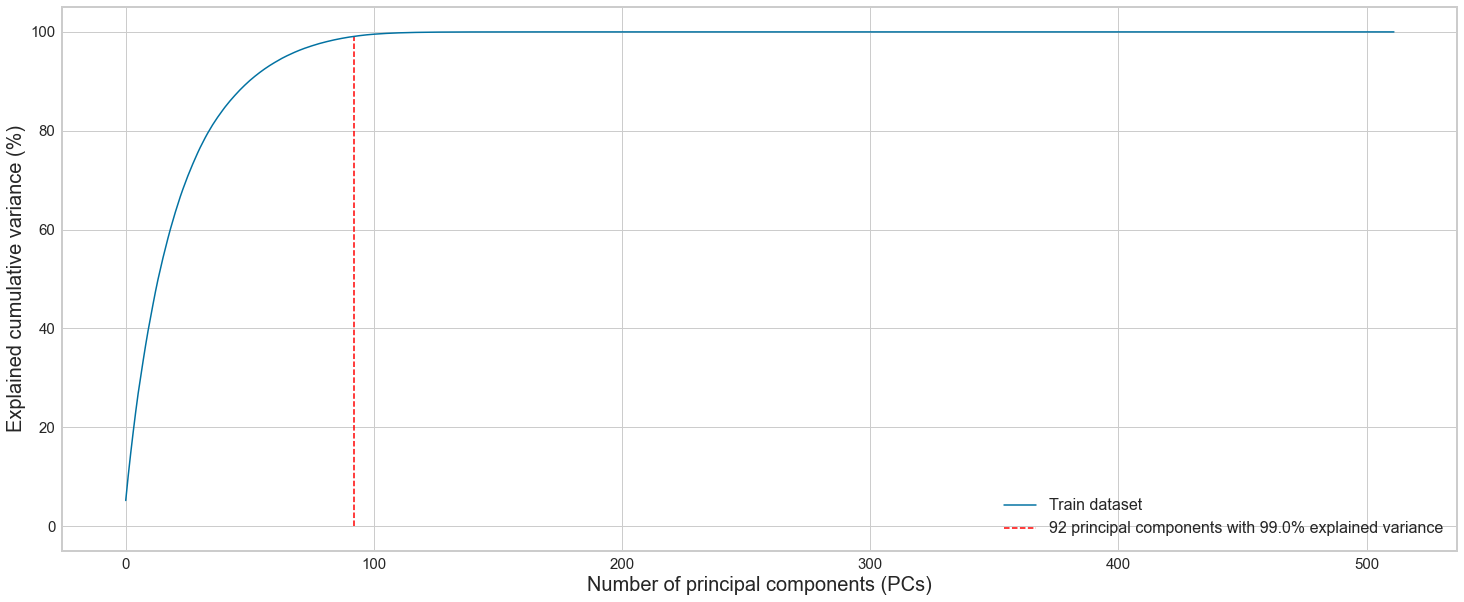

In [14]:
threshold = 0.99 # Maintain 99% of variance in the dataset
pca = dim_reduction.pca(U=U_scaled_train,threshold=threshold)
#path = './pca_models/pca_Kuramoto'
#pca.save_model(path=path)

print('PCA model:', pca.model_red)
pca.plot_pca()

In [15]:
# Reduce dimensionality of the data
U_train_pca = pca.model_red.fit_transform(U_scaled_train)
U_test_pca = pca.model_red.transform(U_scaled_test)

print(U_scaled_train.shape)
print(U_train_pca.shape)

(5400, 512)
(5400, 92)


In [16]:
U_train_reduced = pca.model_red.inverse_transform(U_train_pca)
U_test_reduced = pca.model_red.inverse_transform(U_test_pca)

print(U_scaled_train.shape)
print(U_train_reduced.shape) # Return to the original domain after cutting eigenvectors

# Apply inverse standard scaler transform to obtain dataset in same scale as the original data
U_train_reduced_inverse = scaler.inverse_transform(U_train_reduced)  
U_test_reduced_inverse = scaler.inverse_transform(U_test_reduced)

(5400, 512)
(5400, 512)


In [17]:
# fig, ax, diff = pca.plot_compare(X=X_train,
#                  T=T_train,
#                  U = U_train,
#                  U_reduced = U_train_reduced_inverse)

# print('Mean absolute error (MAE) for training set: {}'.format(diff.mean()))

In [18]:
# fig, ax, diff = pca.plot_compare(X=X_test,
#                  T=T_test,
#                  U = U_test,
#                  U_reduced = U_test_reduced_inverse)

# print('Mean absolute error (MAE) for test set: {}'.format(diff.mean()))

**Energy method:** 

Training set error: 0.1019 \
Test ser error: 0.1856

## Threshold based on optimal truncation (removing noise)

We will apply the following formula to discover the optimal truncation

\begin{equation}
  \beta = \frac{m}{n}
\end{equation}

Where m<. In our case, m = 512 (X dimension) e n = 6000 (y dimension).

With $\beta$, we calculate the parameter $\lambda$

\begin{equation}
  \lambda(\beta) = \left(2(\beta + 1) + \frac{8\beta}{(\beta+1) + (\beta^2 + 14\beta + 1)^{1/2}} \right)^{1/2}
\end{equation}

In [19]:
beta = U.shape[1]/U.shape[0]
#gamma = (2*(beta + 1) + (8*beta)/(beta + 1 + (beta**2 + 14*beta + 1)**(1/2)))**(1/2)
#print('beta: ', beta)
#print('gamma: ', gamma)

In [20]:
#fghfg

In [21]:
#mu = 1.5463 # Obtained from matlab code courtesy of Steve Brunton's book
#omega = gamma/mu

omega = 0.56*beta*3 - 0.95*beta*2 + 1.82*beta + 1.43

#print('mu: ', mu)
print('omega: ', omega)

omega:  1.5665333333333333


In [22]:
singular_values = pca.model.singular_values_
singular_values.shape

(512,)

In [23]:
optimal_threshold = np.median(singular_values)*omega
optimal_threshold

0.023108677642340716

We must cut all eigenvectors with singular values lower than the variable "optimal_threshold" because they are considered noise

In [24]:
np.count_nonzero(singular_values > optimal_threshold)

247

In [25]:
#optimal_threshold = 0.9999999993 
#pca = dim_reduction.pca(U=U_scaled_train,threshold=optimal_threshold)

#print('PCA model:', pca.model_red)
#pca.plot_pca()

In [26]:
# Reduce dimensionality of the data
#U_train_pca2 = pca.model_red.fit_transform(U_scaled_train)
#U_test_pca2 = pca.model_red.transform(U_scaled_test)

#U_train_reduced2 = pca.model_red.inverse_transform(U_train_pca2)
#U_test_reduced2 = pca.model_red.inverse_transform(U_test_pca2)

# Apply inverse standard scaler transform to obtain dataset in same scale as the original data
#U_train_reduced_inverse2 = scaler.inverse_transform(U_train_reduced2)  
#U_test_reduced_inverse2 = scaler.inverse_transform(U_test_reduced2)

In [27]:
#fig, ax, diff = pca.plot_compare(X=X_train,
#                 T=T_train,
#                 U = U_train,
#                 U_reduced = U_train_reduced_inverse2)

#print('Mean absolute error (MAE) for training set: {}'.format(diff.mean()))

In [28]:
#fig, ax, diff = pca.plot_compare(X=X_test,
#                 T=T_test,
#                 U = U_test,
#                 U_reduced = U_test_reduced_inverse2)

#print('Mean absolute error (MAE) for test set: {}'.format(diff.mean()))

Using this method of truncating eigenvectors, we would have used the first 256. This is not viable since we would continue to have many eigenvectors when compared to simply choosing based on the cumulative variance.

This means that the hypothesis of our data matrix X being composed of a noise component $(X_{noise})$ and a low-rank component $(X_{true})$ is not accurate. This is likely due to the chaoticity of the studied system

**Therefore, we will continue to use the 99% variance method to truncate the dataset**

## Final ROM 

In [29]:
scaler2 = StandardScaler()
U_scaled2 = scaler2.fit_transform(U)

# Initializing PCA class
pca = dim_reduction.pca(U=U_scaled2,threshold=threshold)
U_pca = pca.model_red.fit_transform(U_scaled2)
U_pca.shape

(6000, 93)

In [30]:
path = './pca_models/pca_Kuramoto'
pickle.dump(pca, open(path, 'wb'))
path = './pca_models/standardscaler'
pickle.dump(scaler2, open(path, 'wb'))

In [31]:
df = pd.DataFrame(U_pca)
df

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,5.472871,1.217982,6.230086,-0.950462,0.863161,-1.352218,4.725135,-4.429206,1.363932,-2.402084,...,0.039695,-0.630270,0.308148,1.050244,-0.333876,0.449127,-0.441855,-0.368726,-0.432447,-0.882914
1,5.456736,1.030217,6.275587,-0.838791,0.975329,-1.566040,4.830630,-4.338888,1.385022,-2.258257,...,0.147404,-0.569808,0.228097,0.962008,-0.382811,0.409564,-0.477184,-0.388698,-0.435062,-0.945107
2,5.456897,0.833749,6.308572,-0.730643,1.086719,-1.799117,4.927997,-4.225563,1.400620,-2.127380,...,0.242548,-0.516366,0.149444,0.862463,-0.427940,0.364968,-0.508434,-0.396248,-0.439829,-1.011683
3,5.472629,0.629589,6.327787,-0.628478,1.196396,-2.050700,5.015677,-4.089995,1.407393,-2.009958,...,0.321138,-0.470679,0.073507,0.750451,-0.468343,0.317173,-0.533748,-0.388429,-0.447695,-1.079764
4,5.501610,0.419481,6.331751,-0.534753,1.303558,-2.319721,5.092144,-3.933463,1.401821,-1.906113,...,0.379351,-0.432838,0.001851,0.624669,-0.503204,0.268150,-0.551536,-0.362689,-0.459409,-1.145805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-4.149586,1.311779,-1.733645,2.995828,-9.173312,2.279188,-0.460554,2.574104,1.066336,-3.507364,...,-0.036918,-0.512051,-0.068848,-1.805694,0.463720,0.355039,0.098901,-0.125374,-0.235216,0.407625
5996,-3.869611,1.194403,-1.635748,3.000731,-9.144402,2.275107,-0.266543,2.343572,1.135160,-3.420423,...,-0.122714,-0.500166,-0.090656,-1.899794,0.449045,0.344282,0.016293,-0.115707,-0.344555,0.451844
5997,-3.593313,1.100201,-1.565852,3.003578,-9.102322,2.267642,-0.078799,2.113092,1.207276,-3.346010,...,-0.205302,-0.501525,-0.088189,-1.930120,0.445987,0.319806,-0.061623,-0.104652,-0.399071,0.489246
5998,-3.312633,1.021631,-1.519267,3.001866,-9.045092,2.256996,0.095221,1.893864,1.292517,-3.293154,...,-0.281509,-0.515433,-0.060715,-1.899384,0.455328,0.287116,-0.133613,-0.101772,-0.404259,0.513852


# Plotting a sample of the reduced time series

In [32]:
from utils.plotting import plot_samples, plot_autocorrelation, dual_heat_map

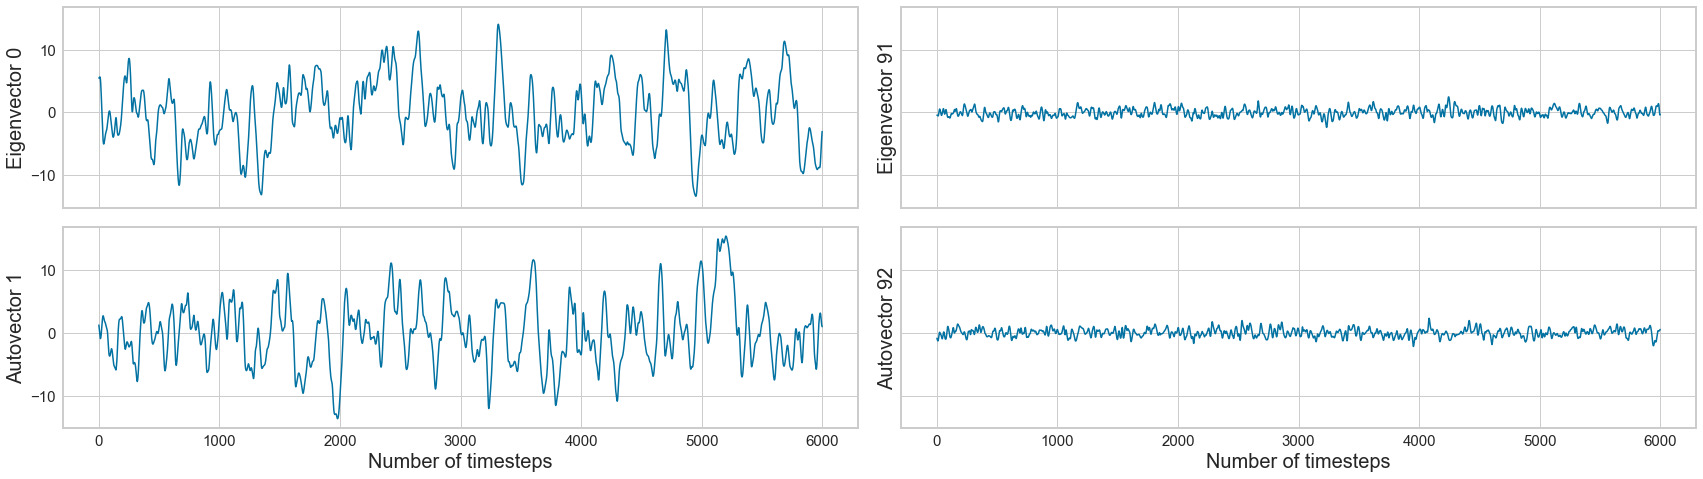

In [33]:
plot_samples(df)

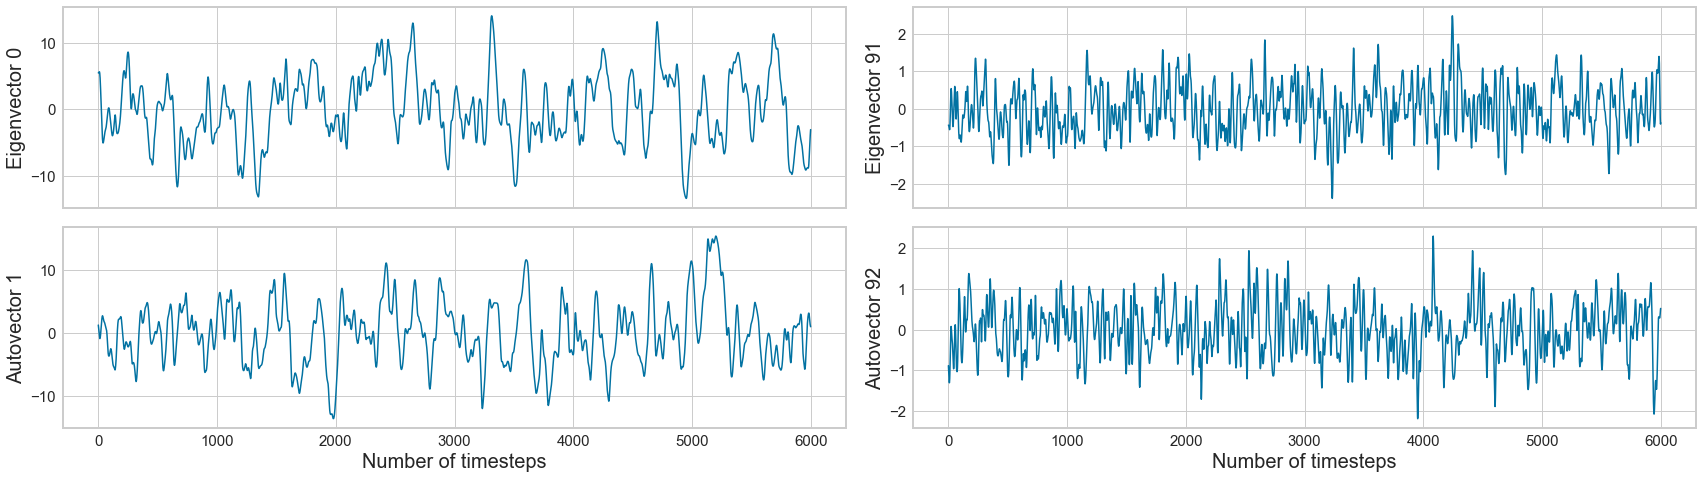

In [34]:
def plot_samples2(df, n_cols=2,n_rows=2):
    fig, ((ax1, ax2), (ax4, ax5)) = plt.subplots(n_rows,n_cols,sharex=True,sharey=False,figsize=(24, 7))

    ax1.plot(df[df.columns[0]], label = df.columns[0])
    ax1.set_ylabel('Eigenvector ' + str(df.columns[0]))

    ax2.plot(df[df.columns[-2]], label = df.columns[-2])
    ax2.set_ylabel('Eigenvector ' + str(df.columns[-2]))

    ax4.plot(df[df.columns[1]], label = df.columns[1])
    ax4.set_ylabel('Autovector ' + str(df.columns[1]))
    ax4.set_xlabel('Number of timesteps')

    ax5.plot(df[df.columns[-1]], label = df.columns[-1])
    ax5.set_ylabel('Autovector ' + str(df.columns[-1]))
    ax5.set_xlabel('Number of timesteps')
    
    plt.tight_layout()
    plt.show()
    
plot_samples2(df)

We can see that the amplitude of the first few time series (which corresponds to the most important eigenvectors) have larger amplitude and lower frequency compared last eigenvectors (lower amplitude/energy and higher frequency).These last eigenvectors appear to be very similar to noise due to its low frequency and amplitude.

# Visualizing the forecasting problem

In [35]:
eigenvector_number = 91
series = pd.DataFrame(df[eigenvector_number]) # First eigenvector
series

,91
0,-0.432447
1,-0.435062
2,-0.439829
3,-0.447695
4,-0.459409
...,...
5995,-0.235216
5996,-0.344555
5997,-0.399071
5998,-0.404259


To use tsfresh, there are a few preprocessing steps that must be done. We must have an "id" column to differentiate experiments and a column to sort the data. We must also define how much into the future we will forecast.

In [36]:
#HORIZON = 15 # Forecast 'HORIZON' time steps into the future
HORIZON=30


series['id'] = [1 for i in range(len(series))]  
series['Time'] = T[:,0] # Column to sort the data
series['t+' + str(HORIZON)] = series[series.columns[0]].shift(-HORIZON)

series.dropna(axis=0,inplace=True)
series

,91,id,Time,t+30
0,-0.432447,1,500.00,0.135194
1,-0.435062,1,500.25,0.041743
2,-0.439829,1,500.50,-0.055737
3,-0.447695,1,500.75,-0.154109
4,-0.459409,1,501.00,-0.248539
...,...,...,...,...
5965,0.964688,1,1991.25,-0.235216
5966,1.006480,1,1991.50,-0.344555
5967,1.032164,1,1991.75,-0.399071
5968,1.042898,1,1992.00,-0.404259


In [37]:
8*MLE

0.752

Text(0.5, 0, 'Number of time steps')

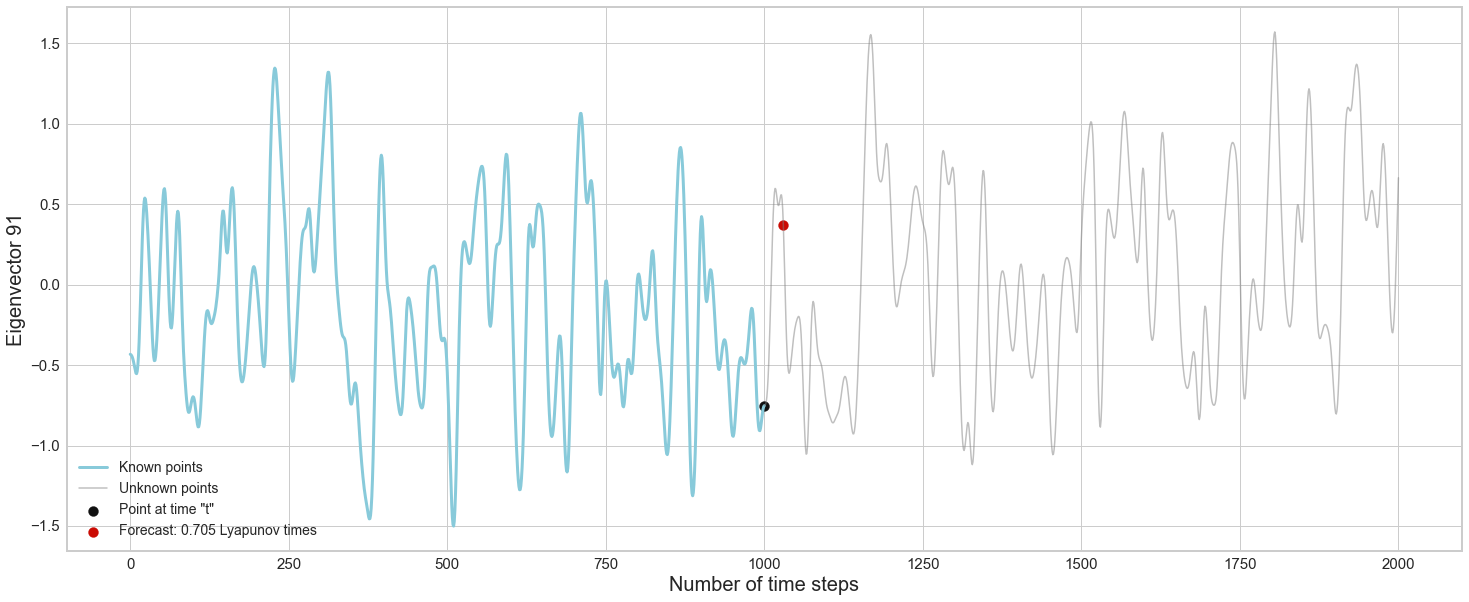

In [38]:
known = series[series.columns[0]].loc[0:1000] # First 1000 values for eigenvector 0 
unknown = series[series.columns[0]].loc[1000:2000] # Next 2000 values for eigenvector 0 
to_predict = series[series.columns[-1]].loc[1000]

feat1 = series[series.columns[0]].loc[1000]


fig, ax = plt.subplots()
plt.scatter(1000,feat1, c='k', marker='o',label = 'Point at time "t"')
plt.scatter(1000+HORIZON,to_predict, c='r', marker='o',label = 'Forecast: {} Lyapunov times'.format(HORIZON*0.25*MLE))

known.plot(ax=ax, c='c', label = 'Known points',linewidth=3)
unknown.plot(ax=ax, c='grey', alpha=0.5,label = 'Unknown points')

ax.legend()
ax.set_ylabel('Eigenvector {}'.format(eigenvector_number))
ax.set_xlabel('Number of time steps')

# Training a baseline model

In [39]:
y = series[series.columns[-1]]
X = series.drop(series.columns[1:],axis=1)
X

,91
0,-0.432447
1,-0.435062
2,-0.439829
3,-0.447695
4,-0.459409
...,...
5965,0.964688
5966,1.006480
5967,1.032164
5968,1.042898


In [40]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [41]:
X_train, X_test, y_train, y_test = create_scaled_dataset(X,y) # All tsfresh columns

In [42]:
from sklearn.linear_model import BayesianRidge

#rf = RandomForestRegressor(n_jobs=6,random_state=0)
rf = BayesianRidge()
rf.fit(X_train,y_train)
yhat=rf.predict(X_test)
score = metrics(y_test,yhat)

MSE:0.35338146834130596 
MAE:0.48622486431629164 
R2:0.011417517232295005


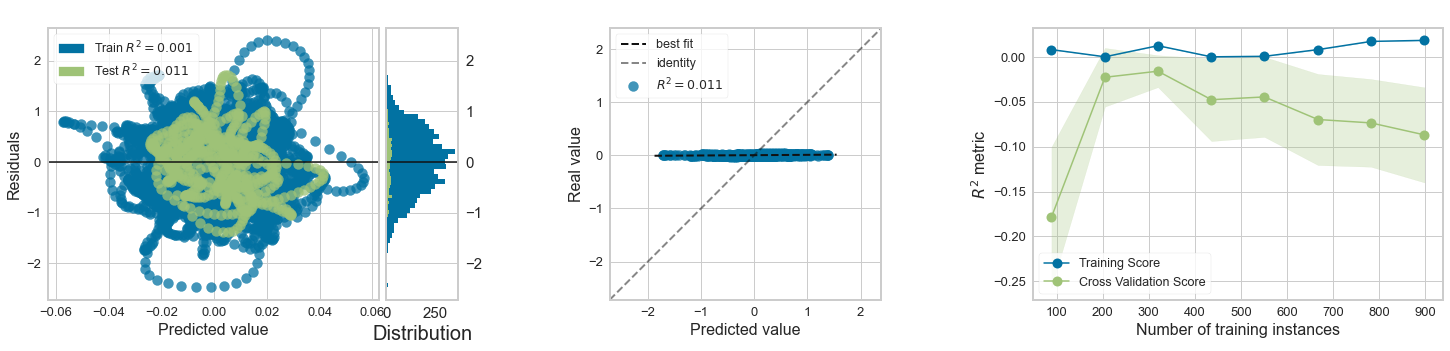

In [43]:
cv = TimeSeriesSplit(n_splits=5)
summary_plot(rf,X_train,y_train,X_test,y_test,cv,train_sizes=np.linspace(0.1,1,8))

# Lag features

For random data, autocorrelations should be near zero for all lags (white noise).  Non-random data have at least one significant lag. When the data are not random, it’s a good indication that you need to use a time series analysis or incorporate lags into a regression analysis to model the data appropriately.



Looking again into stationarity, our signal must:

- Not have a trend (mean=0);
- Have constant variance;
- Have a constant autocorrelation pattern (below the confidence interval);
- Have no seasonal pattern.

The autocorrelation function (ACF) declines to near zero rapidly for a stationary time series. For a non-stationary time series, the ACF drops slowly. There is also no seasonal components since there are no repetitive peaks in defined multiples.

The confidence interval of 95% is represented by the shaded cone. Values outside the cone suggest very likely correlation and not a statistical fluke. 

Let us now take a closer look at the partial autocorrelation (PACF). Instead of finding correlations of present values with lags like ACF, PACF finds correlation of the residuals with the next lag. It is a function that measures the incremental benefit of adding another lag. So if through the PACF function we discover that there is hidden information in the residual that can be modeled by the next lag, we might get a good correlation, and we will keep that next lag as a feature while modeling.

As mentioned before, an autoregression is a model based on the assumption that present values of a time series can be obtained using previous values of the same time series: the present value is a weighted average of its past values. In order to avoid multicollinear features for time series models, it is necessary to find optimum features or order of the autoregression process using the PACF plot, as it removes variations explained by earlier lags, so we get only the relevant features.

In [44]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


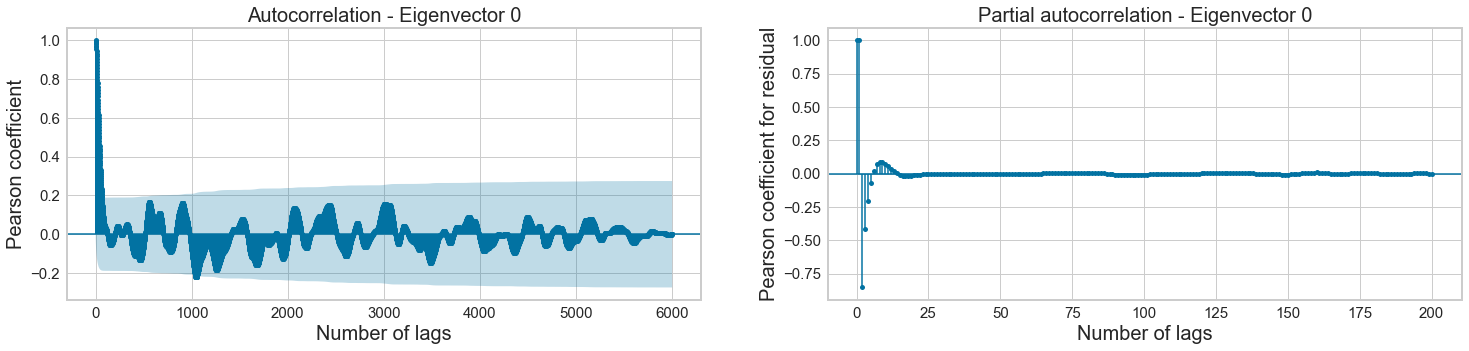

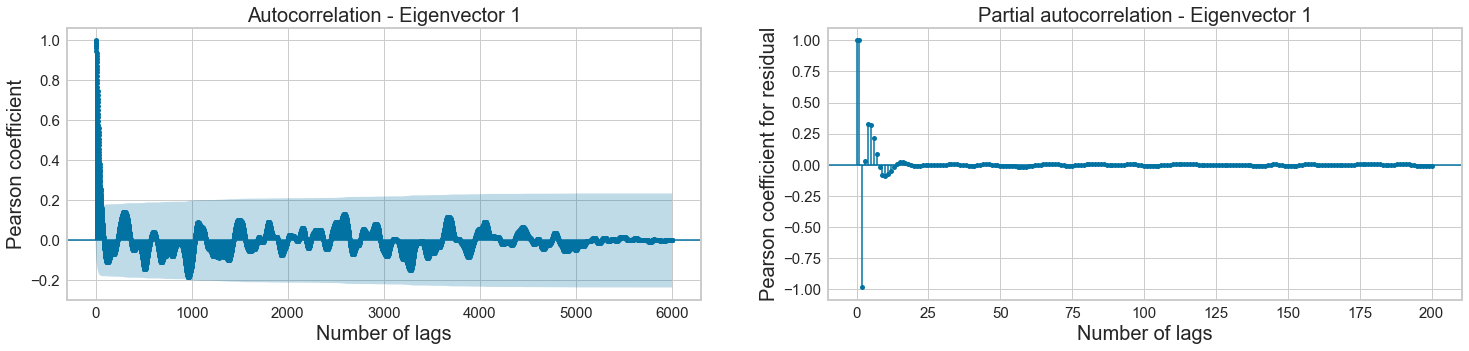

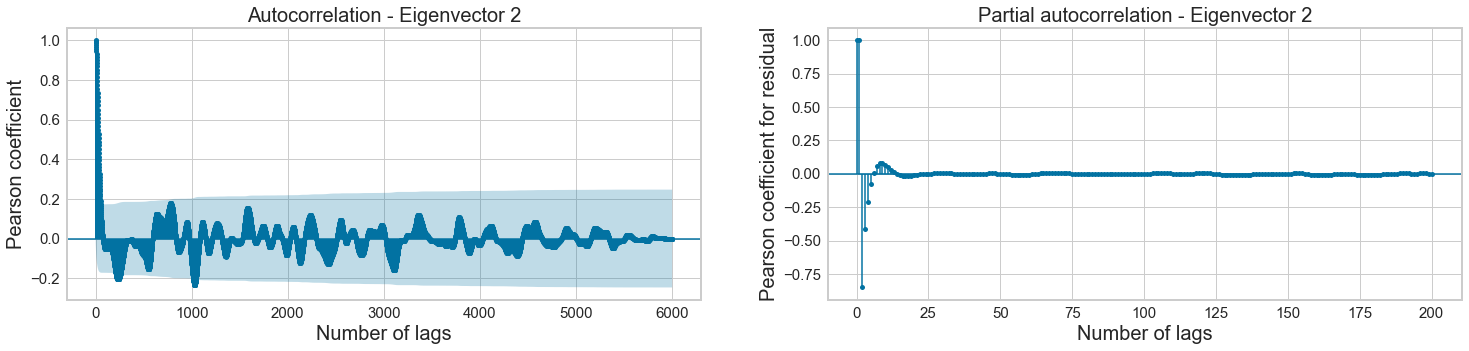

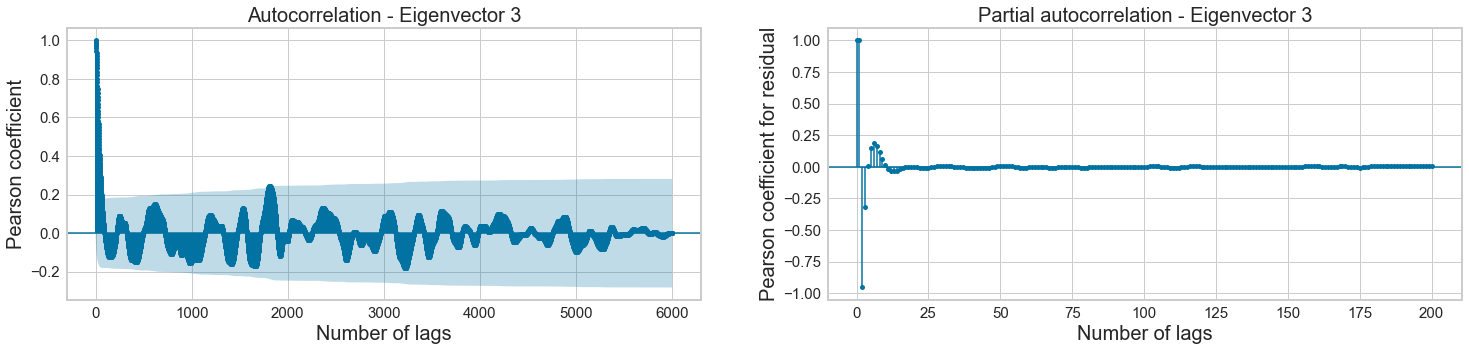

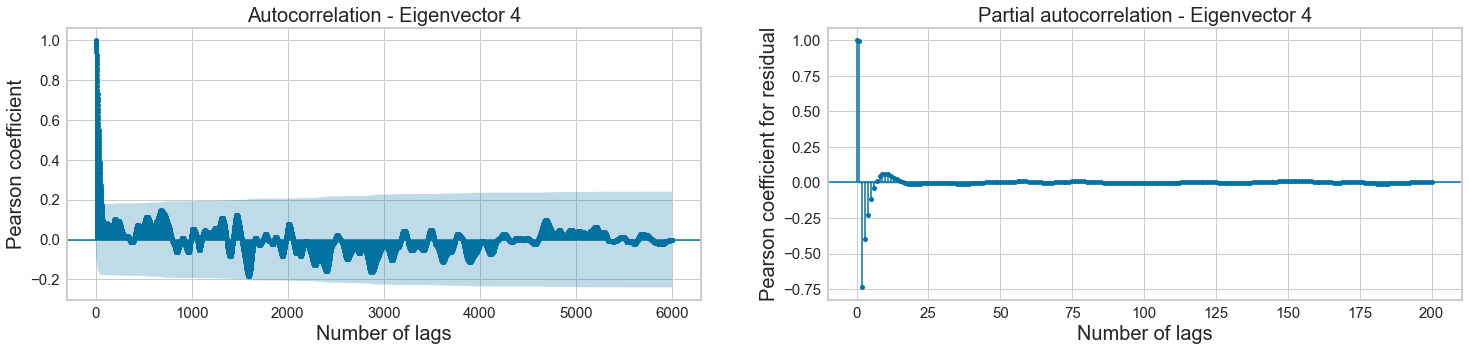

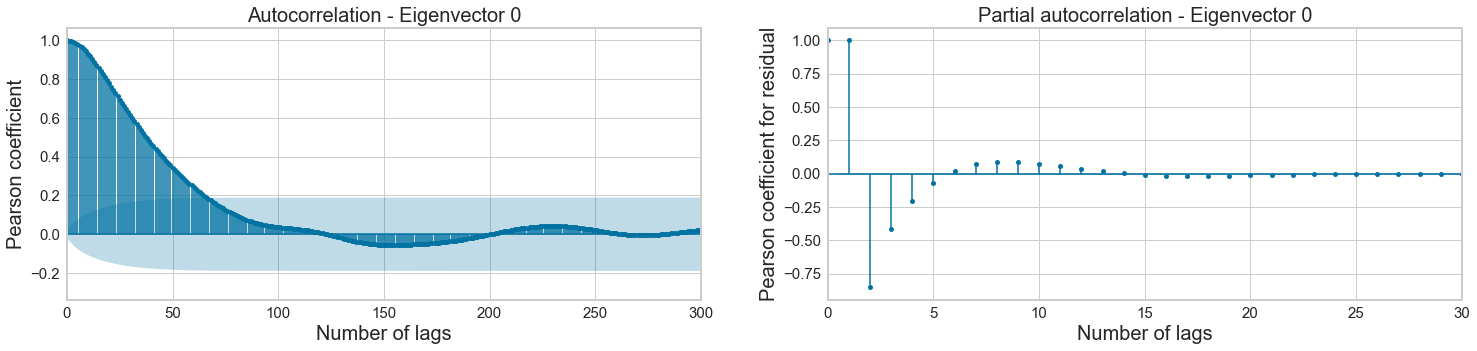

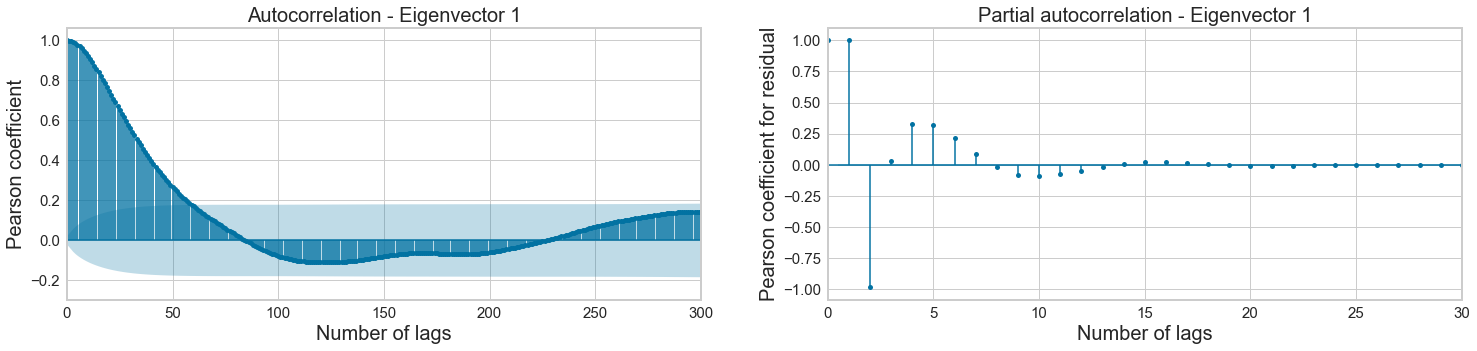

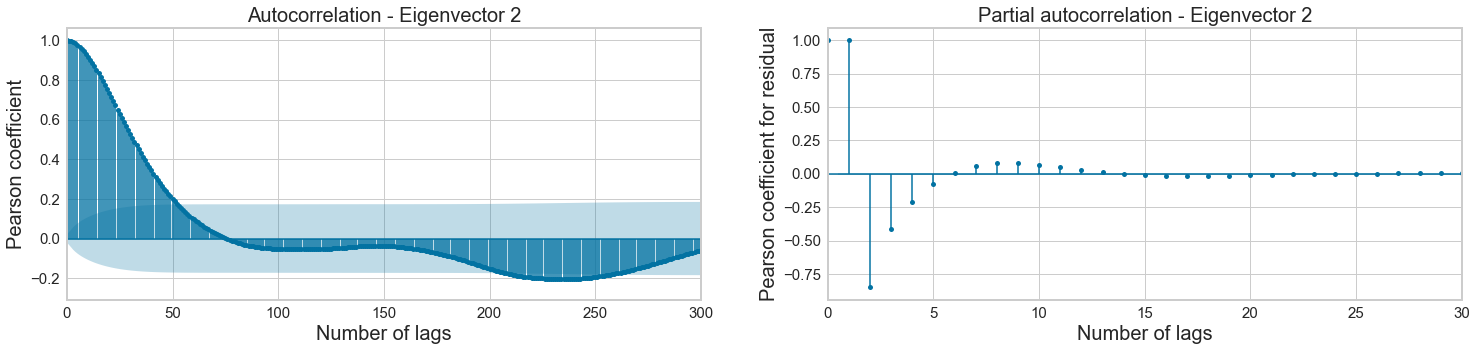

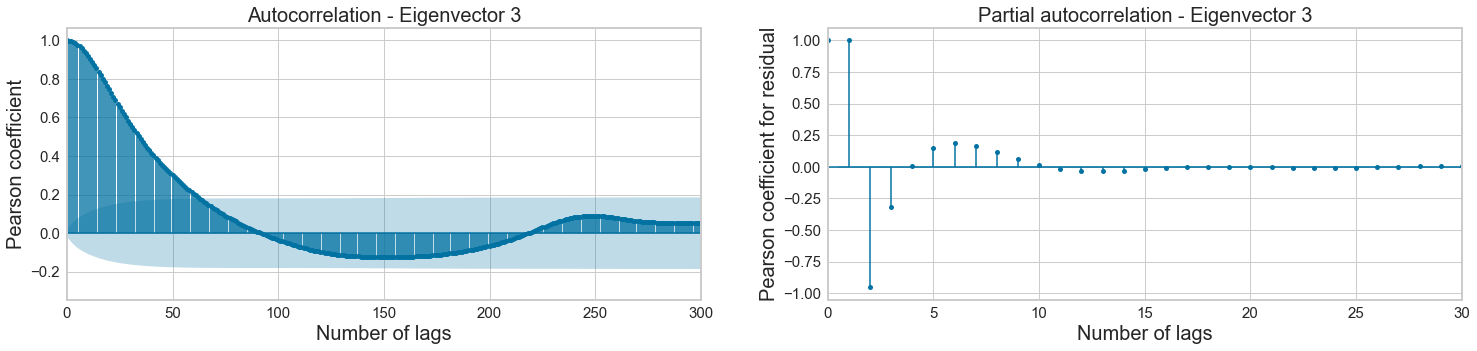

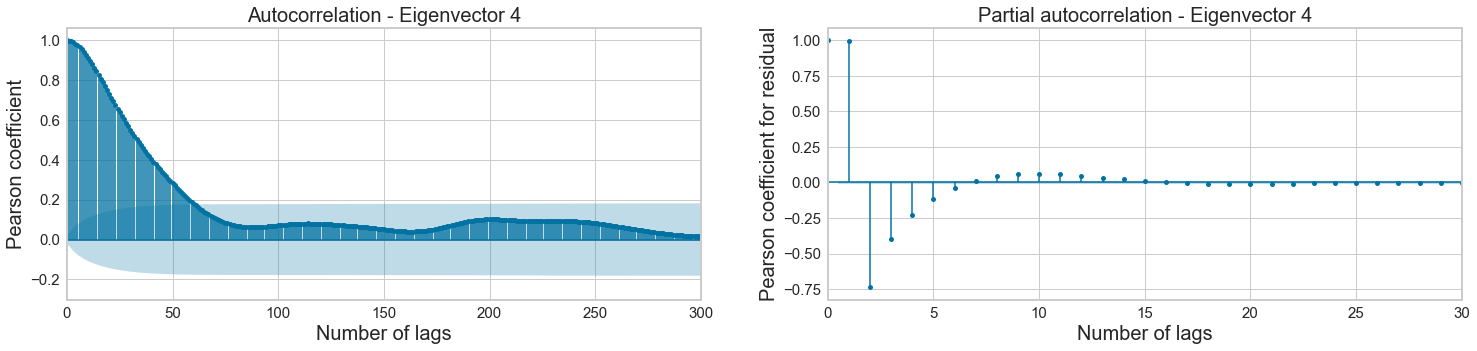

In [45]:
# First eigenvectors
for i in tqdm(range(5)):
    plot_autocorrelation(df,i)
    
for i in tqdm(range(5)):
    plot_autocorrelation(df,i,zoom=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


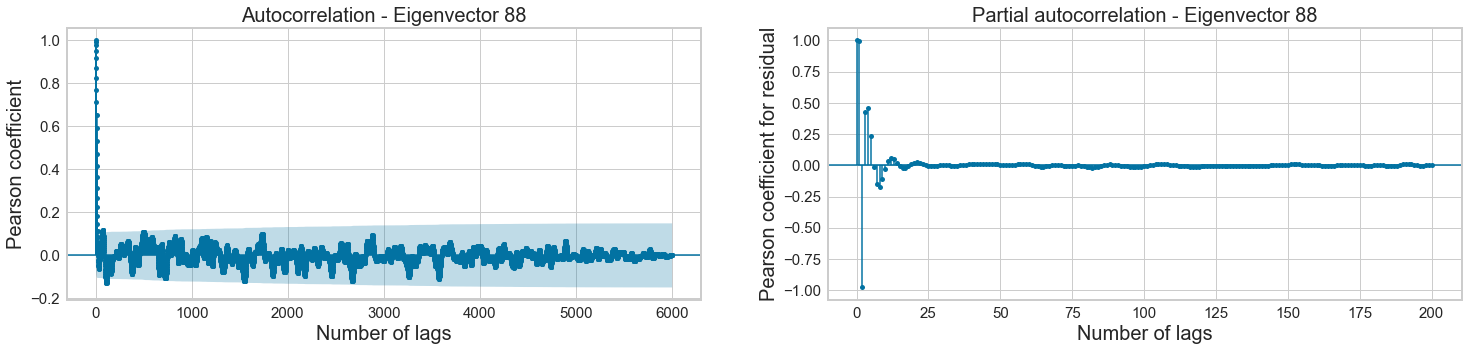

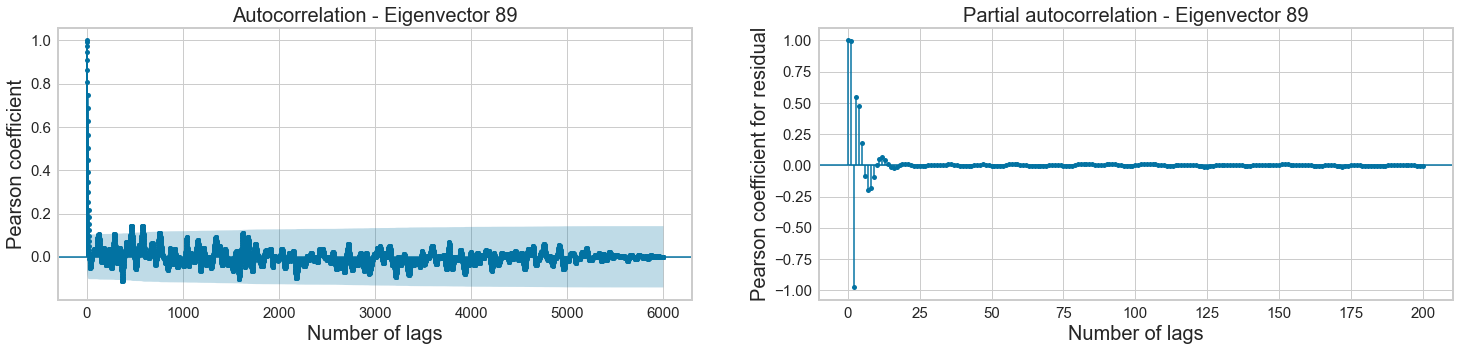

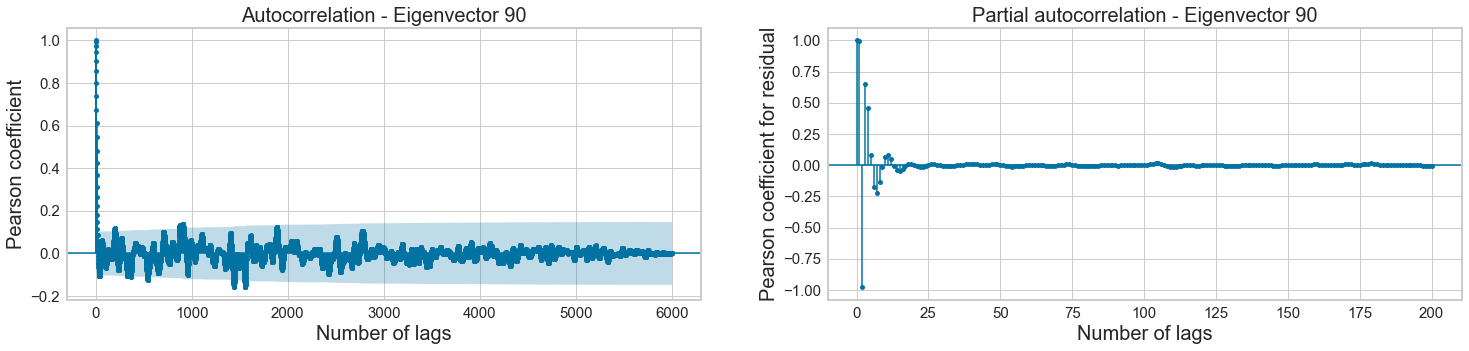

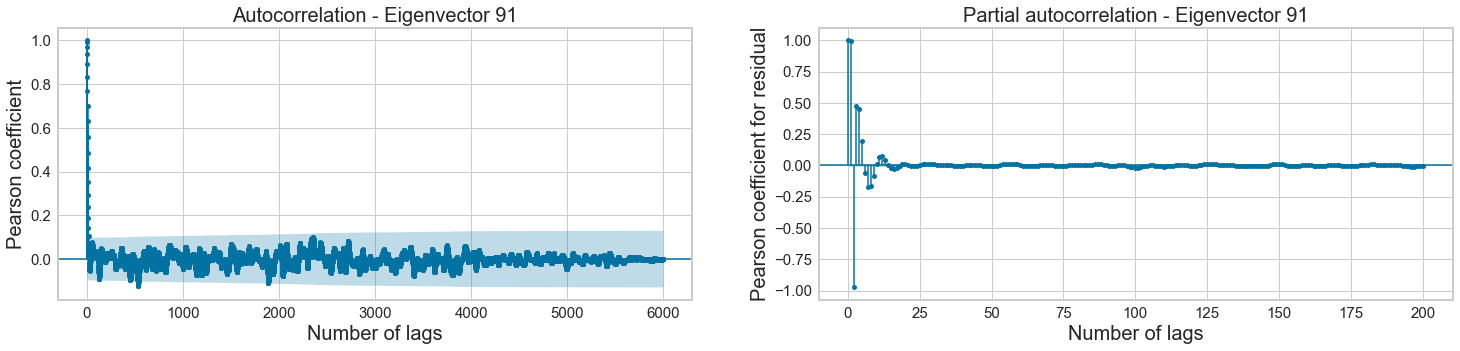

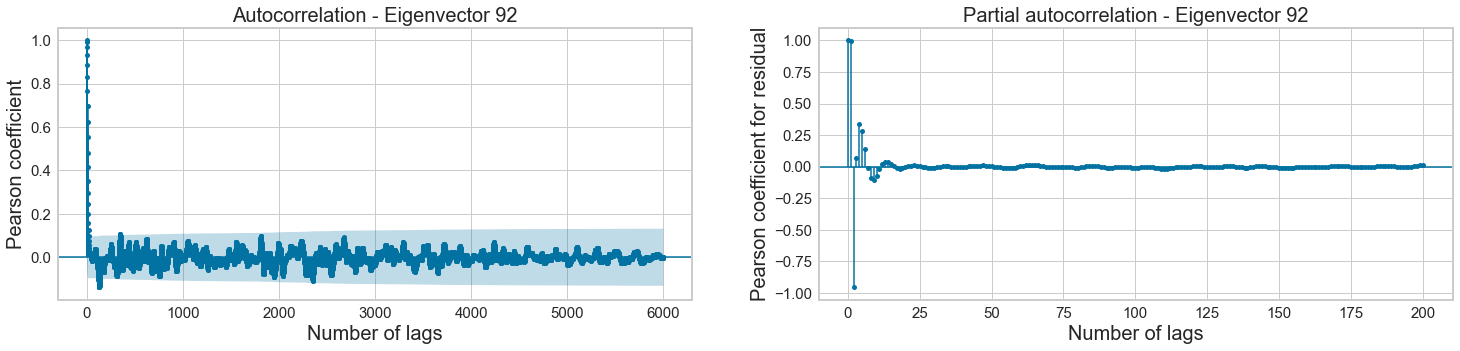

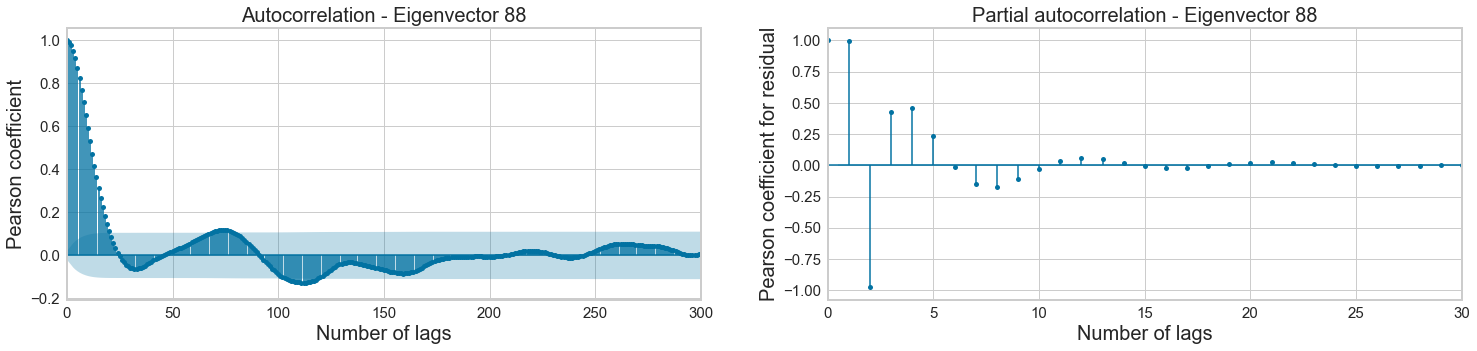

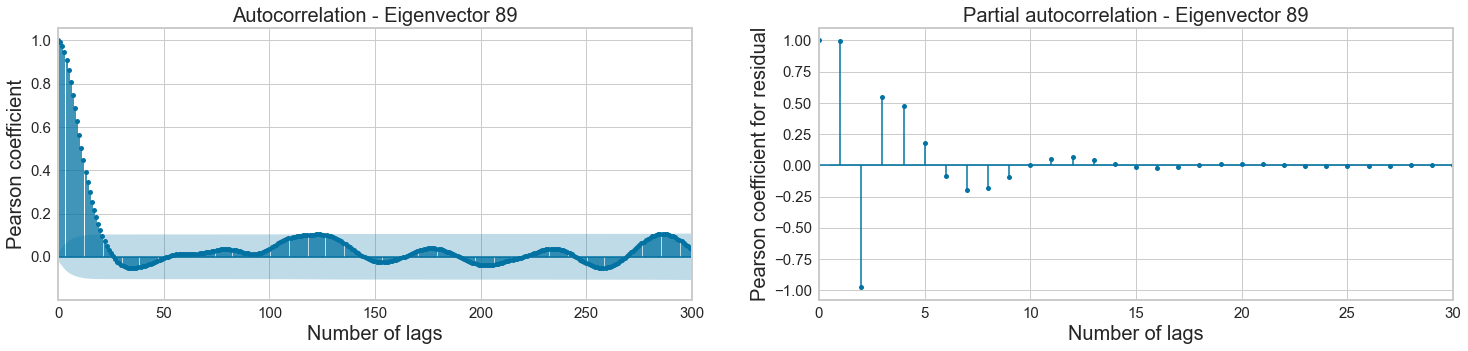

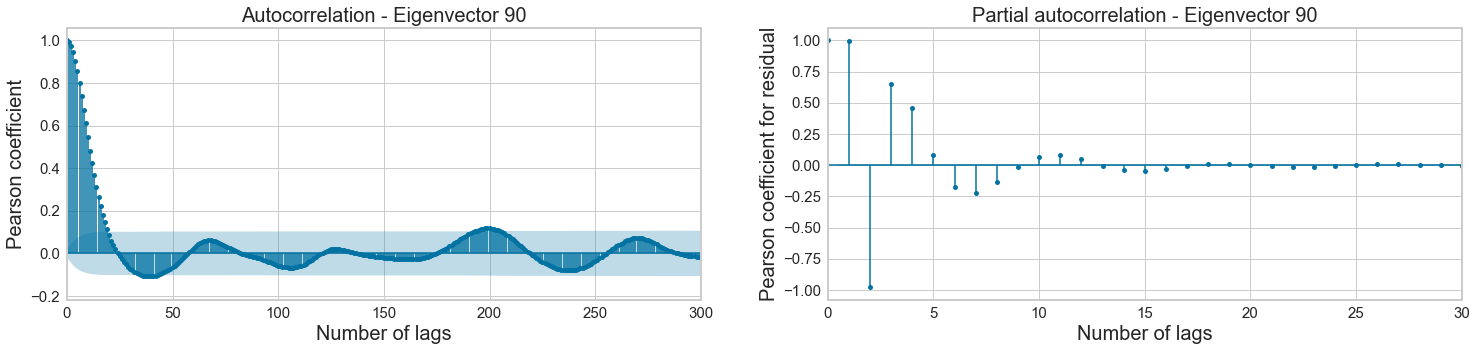

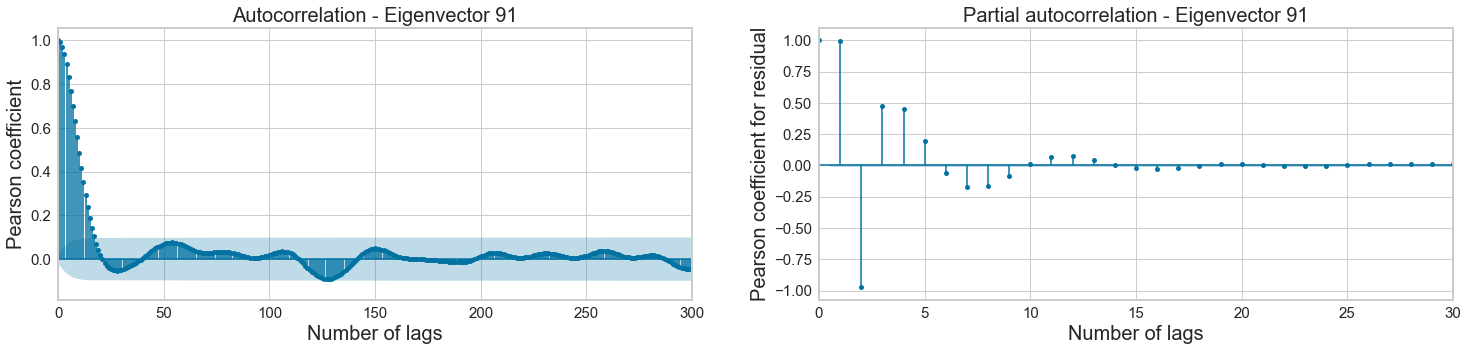

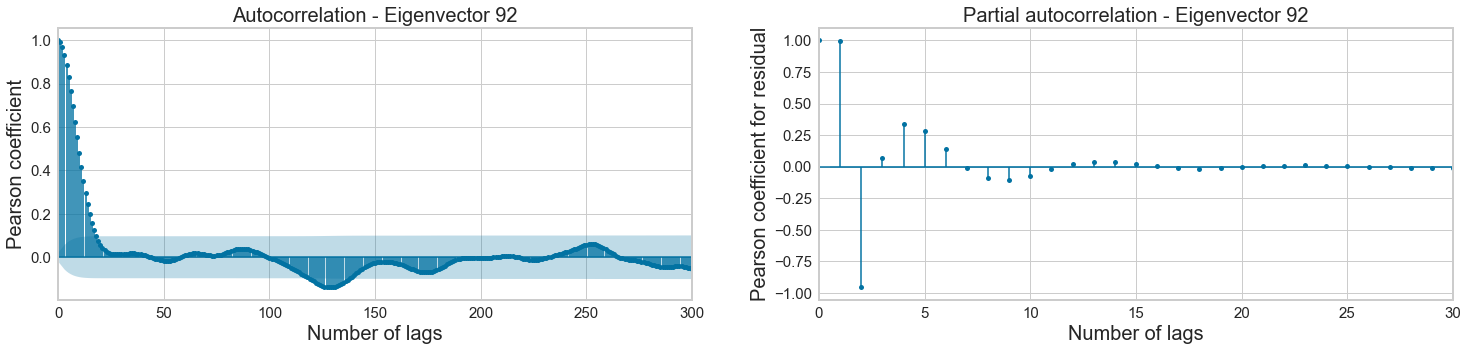

In [46]:
# Last eigenvectors
for i in tqdm(range(5)):
    plot_autocorrelation(df,i+df.shape[1]-5)
    
for i in tqdm(range(5)):
    plot_autocorrelation(df,i+df.shape[1]-5,zoom=True) 

From the autocorrelation plot, we see that our data is non stationary and has no seasonality.

From the partial autocorrelation plots, the most extreme lag that can be used a predictor would a lag between 1 and 4 based on the Pearson coefficient. We will use 4 lags.

Also, the cone of 95% is very small in the PACF plot. This leads us to believe that many lag components have some correlation, even though it is miniscule. Therefore, can be ignored.

## Updating the dataset

In [47]:
def create_dataset(df,series_column_name,nlags=4,HORIZON=100):
    df_series = pd.DataFrame(df[series_column_name]) # Selecting one time series from the dataframe
    df_series.columns=['t']
    
    for k in range(1,nlags): # Create input dataset with lagged features
        label = 't-' + str(k)
        df_series[label] = df_series['t'].shift(k) # lag column of value k
    
    
    df_series['t+' + str(HORIZON-1)] = df_series['t'].shift(-HORIZON)
    
    df_series.dropna(inplace=True)
    return df_series

NLAGS = 5
HORIZON = HORIZON
EIGENVECTOR_NUMBER = series.columns[0]
dataframe = create_dataset(df,EIGENVECTOR_NUMBER,nlags=NLAGS,HORIZON=HORIZON)
dataframe

,t,t-1,t-2,t-3,t-4,t+29
4,-0.459409,-0.447695,-0.439829,-0.435062,-0.432447,-0.248539
5,-0.475235,-0.459409,-0.447695,-0.439829,-0.435062,-0.333025
6,-0.494617,-0.475235,-0.459409,-0.447695,-0.439829,-0.401457
7,-0.515844,-0.494617,-0.475235,-0.459409,-0.447695,-0.448823
8,-0.535814,-0.515844,-0.494617,-0.475235,-0.459409,-0.472135
...,...,...,...,...,...,...
5965,0.964688,0.906209,0.831078,0.740032,0.634651,-0.235216
5966,1.006480,0.964688,0.906209,0.831078,0.740032,-0.344555
5967,1.032164,1.006480,0.964688,0.906209,0.831078,-0.399071
5968,1.042898,1.032164,1.006480,0.964688,0.906209,-0.404259


## Improving baseline model

In [48]:
y2 = dataframe[dataframe.columns[-1]]
X2 = dataframe.drop([dataframe.columns[-1]],axis=1)

X_train2, X_test2, y_train2, y_test2 = create_scaled_dataset(X2,y2) # All tsfresh columns

In [49]:
#rf = RandomForestRegressor(n_jobs=6,random_state=0)

ridge2 = BayesianRidge()
ridge2.fit(X_train2,y_train2)
yhat2=ridge2.predict(X_test2)
score = metrics(y_test2,yhat2)

MSE:0.35425585752888955 
MAE:0.48738227571339837 
R2:0.00897141886153452


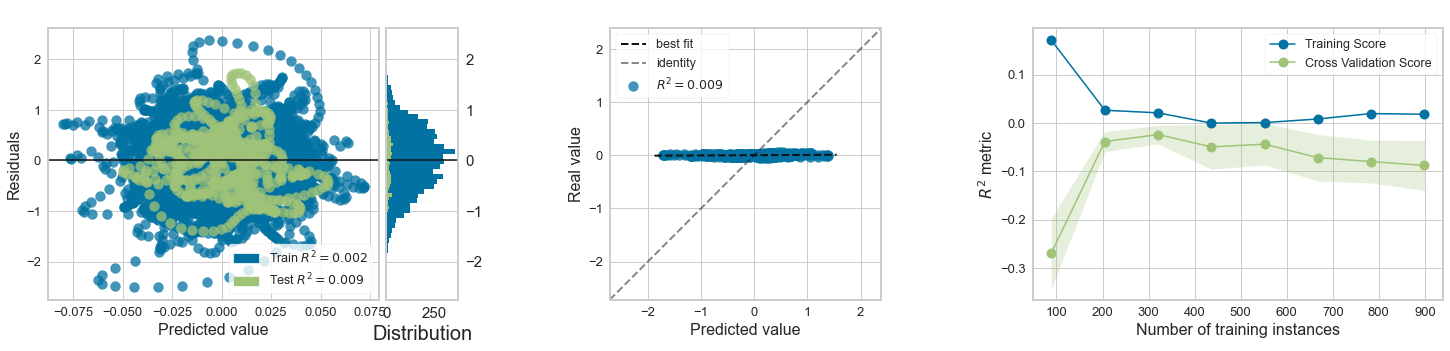

In [50]:
cv = TimeSeriesSplit(n_splits=5)
summary_plot(ridge2,X_train2,y_train2,X_test2,y_test2,cv,train_sizes=np.linspace(0.1,1,8))

All models for determining feature importance
[Lasso(), RandomForestRegressor(n_jobs=-1, random_state=0), AdaBoostRegressor(random_state=0), GradientBoostingRegressor(random_state=0), ExtraTreesRegressor(n_jobs=-1, random_state=0), XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=0,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=123, subsample=None,
             tree_method='gpu_hist', validate_parameters=None, verbosity=None)]

Obtaining feature importance - 0%
Obtaining feature importance - 50%


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Obtaining feature importance - 100%
Obtaining R2 score for all 6 models


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.20it/s]


R2 score calculated


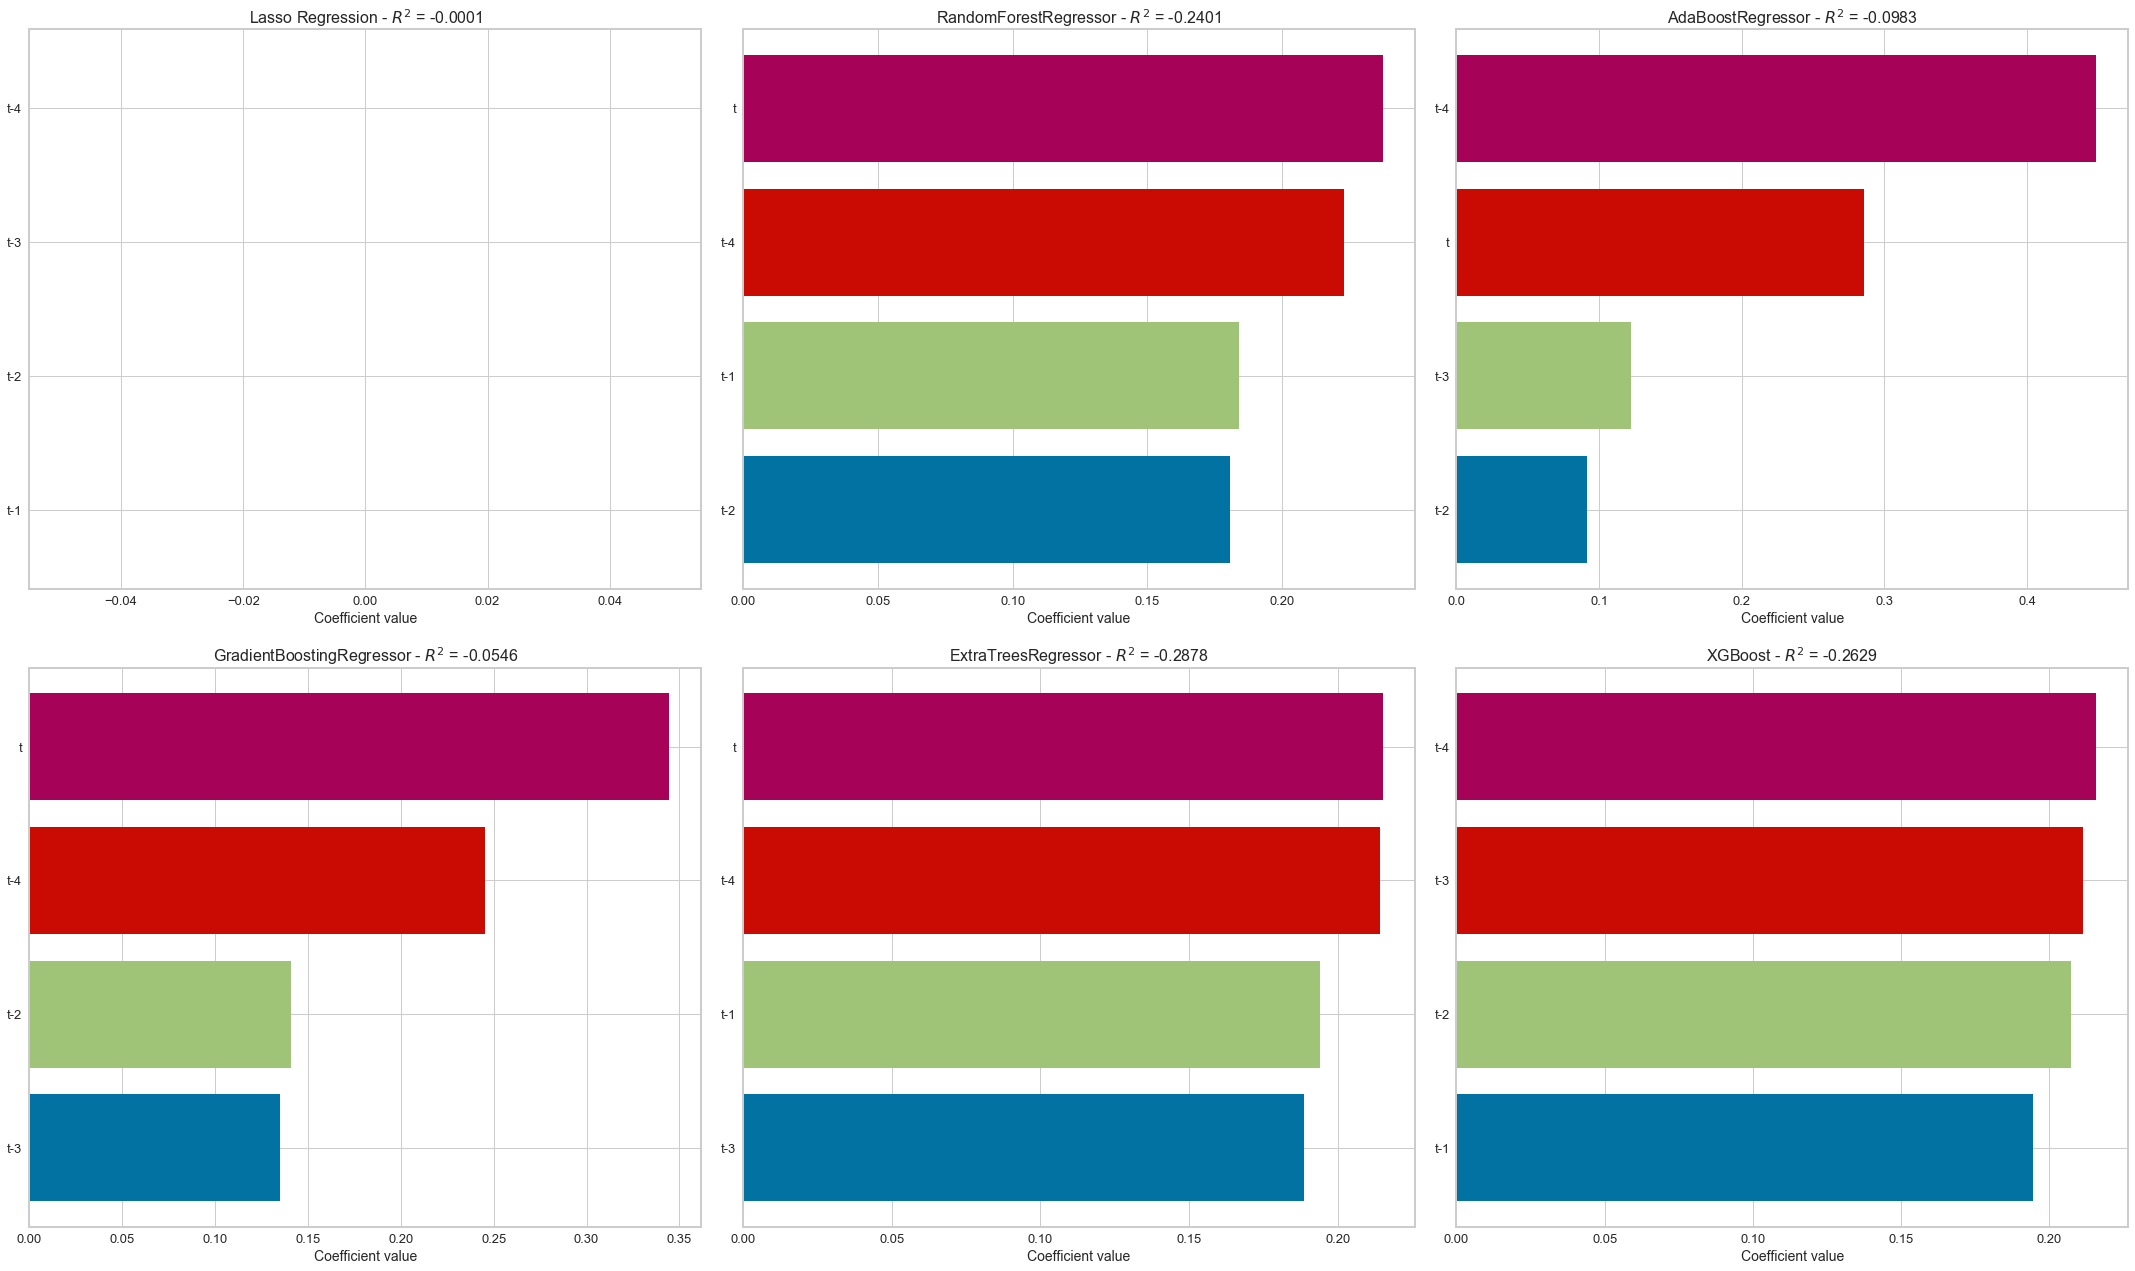

In [51]:
multi_select = multivariate_importance(X_train2,X_test2,y_train2,y_test2)
multi_select.plot(relative=False,topn=4)

# Time domain features + lag features

In [52]:
X_aux = X.copy()

In [53]:
def time_features(x, window):
    nan = [np.nan, np.nan, np.nan, np.nan, np.nan, 
           np.nan, np.nan, np.nan, np.nan, np.nan,
           np.nan, np.nan, np.nan]

    N = len(x.index)
    if N != window:
        return nan

    x = x.to_numpy()
    
    try:
        x_abs = abs(x)
        p1 = x.mean()
        p2 = x.std()
        p3 = (np.sqrt(x_abs)).mean()
        p4 = p3*p3
        p5 = np.sqrt((x*x).mean())
        p6 = max(x_abs)
        p7 = sp.stats.skew(x)
        p8 = sp.stats.kurtosis(x)
        p9 = p5/((np.sum(x_abs)/len(x))**2) # clearance_factor
        p10 = p5/p4 # crest_factor
        p11 = p5/p1 # impulse factor
        p12 = p4/p1 # shape_factor
        p13 = x.max() - x.min() #peak_to_peak

        return [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13]
    
    except ZeroDivisionError:
        return nan

In [54]:
def time_feature_creation(window, df, columns):
    df_rolling = df[columns].rolling(window=window)
    for c in columns:
        colnames = ["{}_p1_{}samples".format(c,str(window)), "{}_p2_{}samples".format(c,str(window)), 
                    "{}_p3_{}samples".format(c,str(window)), "{}_p4_{}samples".format(c,str(window)), 
                    "{}_p5_{}samples".format(c,str(window)), "{}_p6_{}samples".format(c,str(window)), 
                    "{}_p7_{}samples".format(c,str(window)), "{}_p8_{}samples".format(c,str(window)),
                    "{}_p9_{}samples".format(c,str(window)), "{}_p10_{}samples".format(c,str(window)),
                    "{}_p11_{}samples".format(c,str(window)), "{}_p12_{}samples".format(c,str(window)),
                    "{}_p13_{}samples".format(c,str(window))]
        df[colnames] = pd.DataFrame([time_features(x[c], window) for x in df_rolling], columns=colnames, index=df.index)

In [55]:
janelas = [3,10,15] 
columns = X_aux.columns
columns

Index([91], dtype='object')

In [56]:
for i in tqdm(janelas):
    time_feature_creation(i, X, columns)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.80s/it]


In [57]:
X_windowed = X.dropna(axis=0)
X_windowed

,91,91_p1_3samples,91_p2_3samples,91_p3_3samples,91_p4_3samples,91_p5_3samples,91_p6_3samples,91_p7_3samples,91_p8_3samples,91_p9_3samples,...,91_p4_15samples,91_p5_15samples,91_p6_15samples,91_p7_15samples,91_p8_15samples,91_p9_15samples,91_p10_15samples,91_p11_15samples,91_p12_15samples,91_p13_15samples
14,-0.356245,-0.433944,0.060291,0.657117,0.431803,0.438113,0.503200,0.207319,-1.5,2.326578,...,0.477117,0.481646,0.553041,0.394288,-0.394615,2.102174,1.009491,-1.006232,-0.996772,0.196796
15,-0.247384,-0.348672,0.079790,0.586454,0.343928,0.357685,0.442388,0.141506,-1.5,2.942160,...,0.462475,0.472858,0.553041,1.351530,1.624940,2.174471,1.022453,-1.014010,-0.991743,0.305657
16,-0.121260,-0.241630,0.096018,0.480821,0.231189,0.260009,0.356245,0.089681,-1.5,4.453349,...,0.434673,0.460388,0.553041,1.597616,1.734847,2.320671,1.059160,-1.033638,-0.975904,0.431781
17,0.014377,-0.118089,0.106887,0.321835,0.103578,0.159279,0.247384,0.044474,-1.5,9.771393,...,0.388225,0.446177,0.553041,1.497097,1.068437,2.565363,1.149273,-1.074803,-0.935202,0.567418
18,0.150297,0.014471,0.110863,0.285269,0.081379,0.111803,0.150297,0.001278,-1.5,12.307394,...,0.365198,0.432687,0.553041,1.299617,0.348028,2.742348,1.184800,-1.153037,-0.973191,0.703338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5965,0.964688,0.900658,0.054687,0.948590,0.899823,0.902317,0.964688,-0.151216,-1.5,1.112344,...,0.384338,0.533635,0.964688,0.054040,-1.440218,2.704939,1.388450,1.938332,1.396040,1.340008
5966,1.006480,0.959126,0.041124,0.979124,0.958683,0.960007,1.006480,-0.200395,-1.5,1.043574,...,0.417303,0.585584,1.006480,-0.091302,-1.432526,2.476769,1.403256,1.593746,1.135748,1.337137
5967,1.032164,1.001111,0.027808,1.000458,1.000917,1.001497,1.032164,-0.282451,-1.5,0.999276,...,0.456146,0.637686,1.032164,-0.237836,-1.378992,2.244599,1.397988,1.391475,0.995341,1.302546
5968,1.042898,1.027181,0.015279,1.013471,1.027124,1.027294,1.042898,-0.454532,-1.5,0.973646,...,0.502400,0.688679,1.042898,-0.386377,-1.279184,2.015737,1.370779,1.261704,0.920428,1.235500


In [58]:
X_concat = pd.concat([X_windowed,X2[X2.columns[1:]]],axis=1)
X_concat2 = X_concat.dropna(axis=0)
X_concat2

,91,91_p1_3samples,91_p2_3samples,91_p3_3samples,91_p4_3samples,91_p5_3samples,91_p6_3samples,91_p7_3samples,91_p8_3samples,91_p9_3samples,...,91_p8_15samples,91_p9_15samples,91_p10_15samples,91_p11_15samples,91_p12_15samples,91_p13_15samples,t-1,t-2,t-3,t-4
14,-0.356245,-0.433944,0.060291,0.657117,0.431803,0.438113,0.503200,0.207319,-1.5,2.326578,...,-0.394615,2.102174,1.009491,-1.006232,-0.996772,0.196796,-0.442388,-0.503200,-0.539068,-0.553041
15,-0.247384,-0.348672,0.079790,0.586454,0.343928,0.357685,0.442388,0.141506,-1.5,2.942160,...,1.624940,2.174471,1.022453,-1.014010,-0.991743,0.305657,-0.356245,-0.442388,-0.503200,-0.539068
16,-0.121260,-0.241630,0.096018,0.480821,0.231189,0.260009,0.356245,0.089681,-1.5,4.453349,...,1.734847,2.320671,1.059160,-1.033638,-0.975904,0.431781,-0.247384,-0.356245,-0.442388,-0.503200
17,0.014377,-0.118089,0.106887,0.321835,0.103578,0.159279,0.247384,0.044474,-1.5,9.771393,...,1.068437,2.565363,1.149273,-1.074803,-0.935202,0.567418,-0.121260,-0.247384,-0.356245,-0.442388
18,0.150297,0.014471,0.110863,0.285269,0.081379,0.111803,0.150297,0.001278,-1.5,12.307394,...,0.348028,2.742348,1.184800,-1.153037,-0.973191,0.703338,0.014377,-0.121260,-0.247384,-0.356245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5965,0.964688,0.900658,0.054687,0.948590,0.899823,0.902317,0.964688,-0.151216,-1.5,1.112344,...,-1.440218,2.704939,1.388450,1.938332,1.396040,1.340008,0.906209,0.831078,0.740032,0.634651
5966,1.006480,0.959126,0.041124,0.979124,0.958683,0.960007,1.006480,-0.200395,-1.5,1.043574,...,-1.432526,2.476769,1.403256,1.593746,1.135748,1.337137,0.964688,0.906209,0.831078,0.740032
5967,1.032164,1.001111,0.027808,1.000458,1.000917,1.001497,1.032164,-0.282451,-1.5,0.999276,...,-1.378992,2.244599,1.397988,1.391475,0.995341,1.302546,1.006480,0.964688,0.906209,0.831078
5968,1.042898,1.027181,0.015279,1.013471,1.027124,1.027294,1.042898,-0.454532,-1.5,0.973646,...,-1.279184,2.015737,1.370779,1.261704,0.920428,1.235500,1.032164,1.006480,0.964688,0.906209


In [59]:
y3 = y[X_concat2.index]
y3

14     -0.177448
15     -0.083546
16      0.015828
17      0.118263
18      0.220993
          ...   
5965   -0.235216
5966   -0.344555
5967   -0.399071
5968   -0.404259
5969   -0.367278
Name: t+30, Length: 5956, dtype: float64

## Improving baseline model

In [60]:
X_train3,X_test3,y_train3,y_test3 = create_scaled_dataset(X_concat2,y3)

In [61]:
ridge3 = BayesianRidge()
ridge3.fit(X_train3,y_train3)
yhat3=ridge3.predict(X_test3)
score = metrics(y_test3,yhat3)

MSE:0.361929277683174 
MAE:0.4883831056318825 
R2:-0.01133291520889168


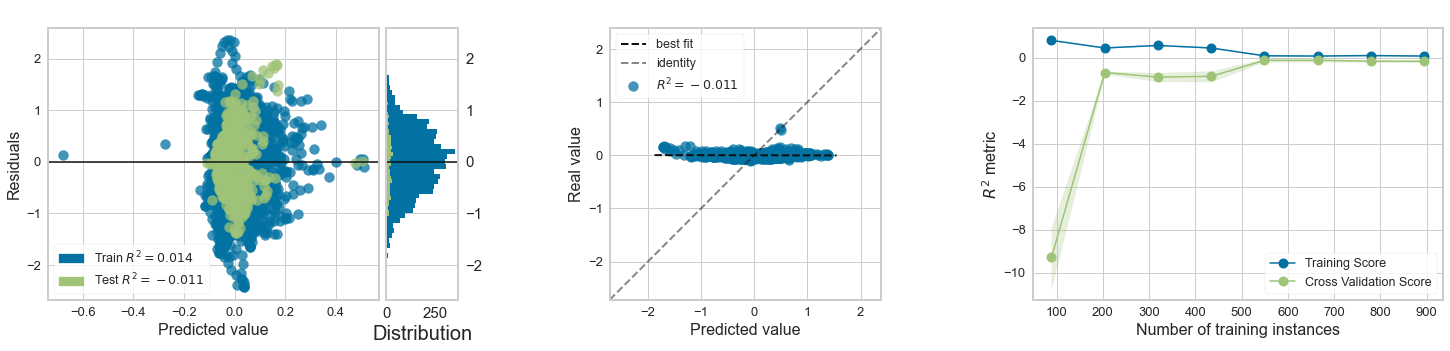

In [62]:
summary_plot(ridge3,X_train3,y_train3,X_test3,y_test3,cv,train_sizes=np.linspace(0.1,1,8))

All models for determining feature importance
[Lasso(), RandomForestRegressor(n_jobs=-1, random_state=0), AdaBoostRegressor(random_state=0), GradientBoostingRegressor(random_state=0), ExtraTreesRegressor(n_jobs=-1, random_state=0), XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=0,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             random_state=0, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, seed=123, subsample=None,
             tree_method='gpu_hist', validate_parameters=None, verbosity=None)]

Obtaining feature importance - 0%
Obtaining feature importance - 50%


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Obtaining feature importance - 100%
Obtaining R2 score for all 6 models


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.67s/it]

R2 score calculated


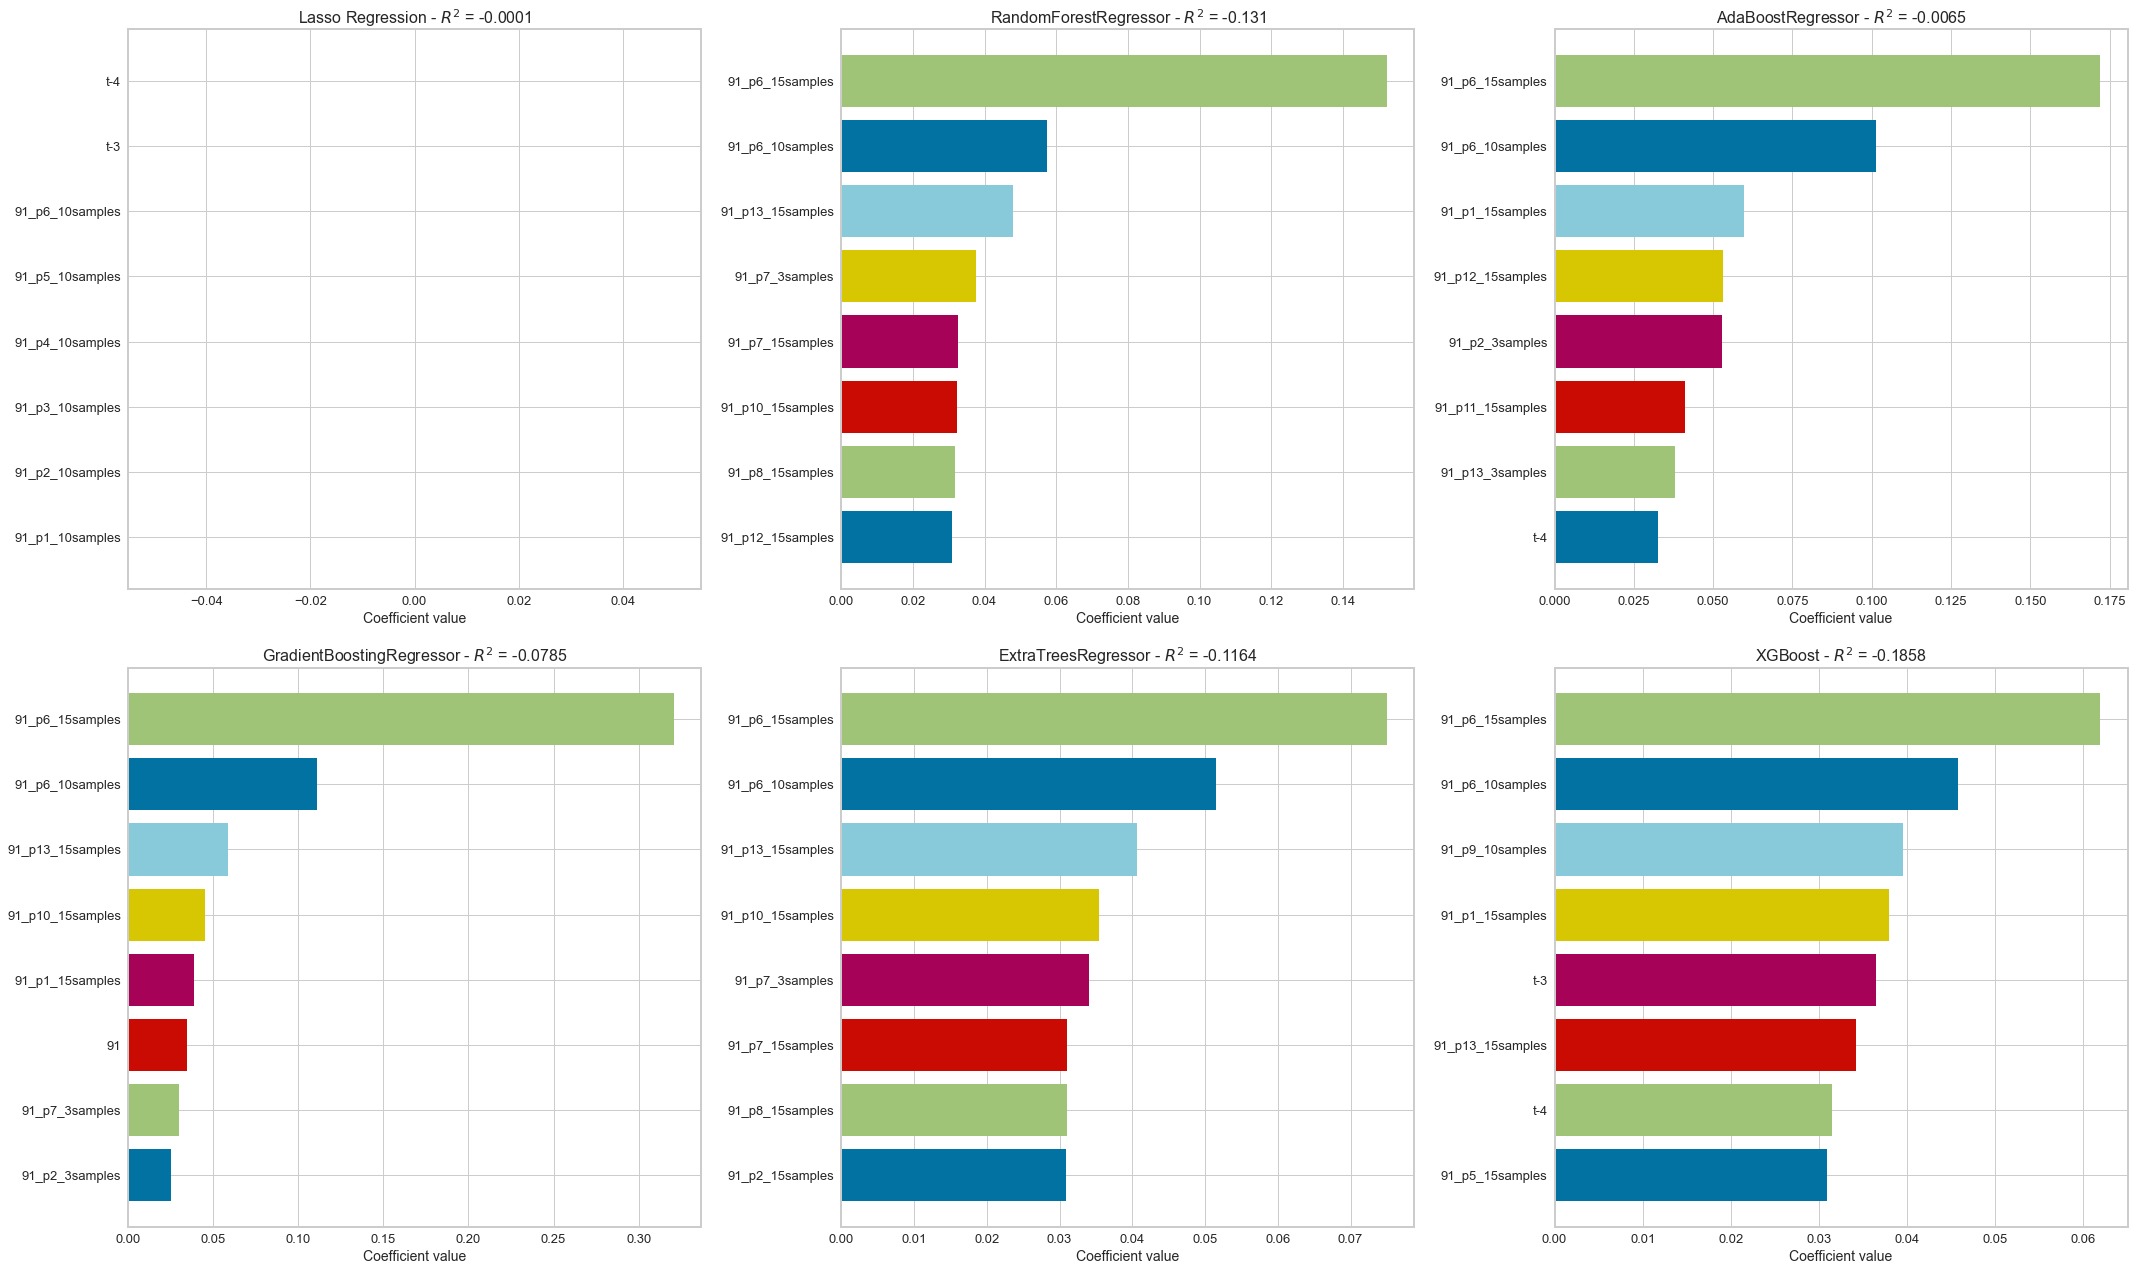

In [63]:
multi_select = multivariate_importance(X_train3,X_test3,y_train3,y_test3)
multi_select.plot(relative=False)

In [64]:
def time_domain_and_lag_features(df,i,windows=[3,5,10,12,15],NLAGS=5,HORIZON=9):
    
    # Create lag features and target columns
    df2 = create_dataset(df,df.columns[i],NLAGS,HORIZON)
    y = df2[df2.columns[-1]]
    X = df2.drop(df2.columns[-1],axis=1)

    # Create time domain features
    series = pd.DataFrame(X[X.columns[0]])
    columns = series.columns
    
    for i in windows:
        time_feature_creation(i, series, columns)
    
    X_windowed = series.dropna(axis=0)
    
    # Join dataframes of time domain and lag variables
    X_concat = pd.concat([X_windowed,X[X.columns[1:]]],axis=1)
    X_concat2 = X_concat.dropna(axis=0)
    y_windowed = y[X_concat2.index]
    
    # Export dataframe
    df_export = pd.concat([X_concat2,y_windowed],axis=1)
    
    return df_export

In [65]:
#time_domain_and_lag_features(df,3,windows=[40],NLAGS=5,HORIZON=9)

# Feature engineering - tsfresh

We will create a model to forecast each individual time series before returning the predictions to the original domain. To help the model understand the underlying relationship to forecasting, feature engineering must be done to create better variables. 

Tsfresh is a tool specifically for feature engineering of time series and will be used here. We will exemplify how it works in this section with an example.

In [66]:
#df_rolled = roll_time_series(series,
#                             column_id="id", 
#                             column_sort="Time",
#                             max_timeshift=40, # Maximum window size of 40 samples. We will look at the last 50 time steps only
#                            )
#df_rolled

In [67]:
#X_features = extract_features(df_rolled,
#                               column_id="id",
#                               column_sort="Time",
#                               column_value = df_rolled.columns[0],
#                               n_jobs=6,
#                               impute_function=impute,
#                               #default_fc_parameters=EfficientFCParameters(),
#                               show_warnings=False)

In [68]:
# X_features

In [69]:
# X_features2 = X_features.droplevel(0)
# X_features2.reset_index(drop=True,inplace=True) 
# X_features2.dropna(axis=1,inplace=True)
# X_features2

In [70]:
# X_filtered = select_features(X_features2, y)
# X_filtered

In [71]:
# X_filtered = pd.concat([X_filtered,series[series.columns[0]]],axis=1)
# X_filtered

## Training model with tsfresh features

In [72]:
# X_features3 = pd.concat([X_features2,series[series.columns[0]]],axis=1)

# X_full_train, X_full_test, y_train, y_test = train_test_split(X_features3, y, test_size=.1,shuffle=True) # All tsfresh columns
# X_filtered_train, X_filtered_test = X_full_train[X_filtered.columns], X_full_test[X_filtered.columns] # filtered columns

In [73]:
# X_full_train

In [74]:
# y_train

### All tsfresh columns

In [75]:
# %%time
# from sklearn.ensemble import RandomForestRegressor

# mdl = RandomForestRegressor(n_jobs=6,random_state=0)
# mdl.fit(X_full_train,y_train)
# yhat=mdl.predict(X_full_test)
# score = metrics(y_test,yhat)

In [76]:
# cv = KFold(n_splits=3,shuffle=True,random_state=0)
# summary_plot(mdl,X_full_train,y_train,X_full_test,y_test,cv,train_sizes=np.linspace(0.1,1,8))

### Filtered columns based on feature importance

In [77]:
# from sklearn.feature_selection import SelectFromModel

# selector = SelectFromModel(estimator=mdl,threshold='6*mean')
# selector.fit(X_full_train,y_train)

In [78]:
# selected_feat= X_full_train.columns[(selector.get_support())]
# print(len(selected_feat))
# print(selected_feat)

In [79]:
# X_train_2 = X_full_train[selected_feat]
# X_test_2 = X_full_test[selected_feat]
# X_test_2

In [80]:
# %%time
# mdl2 = RandomForestRegressor(n_estimators=100,n_jobs=6,random_state=0)
# mdl2.fit(X_train_2,y_train)
# yhat=mdl2.predict(X_test_2)
# score = metrics(y_test,yhat)

In [81]:
# summary_plot(mdl2,X_train_2,y_train,X_test_2,y_test,cv,train_sizes=np.linspace(0.1,1,8))

In [82]:
# y_test

In [83]:
# y_test.sort_index(ascending=True)

### Filtered columns with tsfresh

In [84]:
# %%time
# mdl = RandomForestRegressor(n_estimators=100,n_jobs=6,random_state=0)
# mdl.fit(X_filtered_train,y_train)
# yhat=mdl.predict(X_filtered_test)
# score = metrics(y_test,yhat)

In [85]:
# summary_plot(mdl,X_filtered_train,y_train,X_filtered_test,y_test,cv,train_sizes=np.linspace(0.1,1,8))

Filtering based on feature importance appears to be better option than what tsfresh has availible. We will use a RandomForestRegressor with default hyperparameters for feature selection for **ALL** time series

## Plotting - ordered dataset with reduced features

In [86]:
# X_train, X_test, y_train, y_test = train_test_split(X_features2, y, test_size=.1,shuffle=False) 

# X_train_2 = X_train[selected_feat]
# X_test_2 = X_test[selected_feat]

In [87]:
# yhat = mdl2.predict(X_test_2) # Using already trained model
# score = metrics(y_test,yhat)

In [88]:
# plt.plot(y_test.index,yhat,label='Forecast')
# plt.plot(y_test.index,y_test,label='Target')
# plt.legend()

In [89]:
# summary_plot(mdl2,X_train_2,y_train,X_test_2,y_test,cv,train_sizes=np.linspace(0.1,1,8))

# Creating the dataset

The function below is responsible for creating a dataset so as to reframe the forecasting problem as a regression problem. A single time series is used as the input and the final dataset is obtained as the output

In [90]:
# def create_dataset(df,EIGENVECTOR_NUMBER,HORIZON,tsfresh_max_time_shift=50):
#     series = pd.DataFrame(df[EIGENVECTOR_NUMBER]) # First eigenvector
    
#     # Preprocessing for applying tsfresh
#     series['id'] = [1 for i in range(len(series))]  
#     series['Time'] = T[:,0] # Column to sort the data
#     series['t+' + str(HORIZON)] = series[series.columns[0]].shift(-HORIZON)
#     series.dropna(axis=0,inplace=True)
    
#     y = series[series.columns[-1]] # Target variable
    
#     # Applying tsfresh for feature extraction from the time vector
#     X_rolled = roll_time_series(series,
#                                  column_id="id", 
#                                  column_sort="Time",
#                                  max_timeshift=tsfresh_max_time_shift,
#                                  disable_progressbar=True
#                                 )
    
#     X_features = extract_features(X_rolled,
#                                column_id="id",
#                                column_sort="Time",
#                                column_value = X_rolled.columns[0],
#                                n_jobs=6,
#                                impute_function=impute,
#                                default_fc_parameters=EfficientFCParameters(),
#                                show_warnings=False,
#                                disable_progressbar=True)
    
    
#     # Processing step to gurantee that the index between the dataframe and target vector are the same
#     X_features = X_features.droplevel(0)
#     X_features.reset_index(drop=True,inplace=True) 
    
#     return X_features, y

In [91]:
#X,y = create_dataset(df,EIGENVECTOR_NUMBER=23,HORIZON=40)

In [92]:
# def filter_dataframe(X,y):
    
#     X_train,X_test,y_train,y_test = create_scaled_dataset(X,y)
    
#     rf = RandomForestRegressor(n_jobs=6,random_state=0)
#     selector = SelectFromModel(estimator=rf,threshold='6*mean') 
#     selector.fit(X_train,y_train)
    
#     selected_feat= X_train.columns[(selector.get_support())]
#     X_train_2 = X_train[selected_feat]
#     X_test_2 = X_test[selected_feat]
    
#     # Fit with reduced data to verify if the performace is still good
#     #rf2 = RandomForestRegressor(n_jobs=6,random_state=0)
#     rf2 = BayesianRidge()
#     rf2.fit(X_train_2,y_train)
#     yhat = rf2.predict(X_test_2)
#     score = metrics(y_test,yhat)
    
#     X = pd.concat([X_train_2,X_test_2],axis=0)
#     df = pd.concat([X,y],axis=1)
#     return df

# Exporting dataset

In [93]:
# Create dataset for each eigenvector 

for i in tqdm(range(df.shape[1])): 
    print('Eigenvector ', i)
    df_export = time_domain_and_lag_features(df,i,windows=[40],NLAGS=5,HORIZON=HORIZON)
    df_export.to_csv('dataframe_time_series/df_time_series_{}.csv'.format(i)) # save dataframe for specific eigenvector

  0%|                                                                                           | 0/93 [00:00<?, ?it/s]

Eigenvector  0


  1%|▉                                                                                  | 1/93 [00:03<04:48,  3.13s/it]

Eigenvector  1


  2%|█▊                                                                                 | 2/93 [00:06<04:40,  3.09s/it]

Eigenvector  2


  3%|██▋                                                                                | 3/93 [00:09<04:33,  3.04s/it]

Eigenvector  3


  4%|███▌                                                                               | 4/93 [00:12<04:31,  3.05s/it]

Eigenvector  4


  5%|████▍                                                                              | 5/93 [00:15<04:25,  3.02s/it]

Eigenvector  5


  6%|█████▎                                                                             | 6/93 [00:18<04:22,  3.02s/it]

Eigenvector  6


  8%|██████▏                                                                            | 7/93 [00:21<04:19,  3.02s/it]

Eigenvector  7


  9%|███████▏                                                                           | 8/93 [00:24<04:14,  3.00s/it]

Eigenvector  8


 10%|████████                                                                           | 9/93 [00:27<04:10,  2.99s/it]

Eigenvector  9


 11%|████████▊                                                                         | 10/93 [00:30<04:06,  2.97s/it]

Eigenvector  10


 12%|█████████▋                                                                        | 11/93 [00:33<04:04,  2.98s/it]

Eigenvector  11


 13%|██████████▌                                                                       | 12/93 [00:36<04:01,  2.98s/it]

Eigenvector  12


 14%|███████████▍                                                                      | 13/93 [00:39<03:58,  2.98s/it]

Eigenvector  13


 15%|████████████▎                                                                     | 14/93 [00:42<03:57,  3.01s/it]

Eigenvector  14


 16%|█████████████▏                                                                    | 15/93 [00:45<03:54,  3.01s/it]

Eigenvector  15


 17%|██████████████                                                                    | 16/93 [00:48<03:52,  3.01s/it]

Eigenvector  16


 18%|██████████████▉                                                                   | 17/93 [00:51<03:48,  3.00s/it]

Eigenvector  17


 19%|███████████████▊                                                                  | 18/93 [00:54<03:45,  3.01s/it]

Eigenvector  18


 20%|████████████████▊                                                                 | 19/93 [00:57<03:42,  3.01s/it]

Eigenvector  19


 22%|█████████████████▋                                                                | 20/93 [01:00<03:40,  3.02s/it]

Eigenvector  20


 23%|██████████████████▌                                                               | 21/93 [01:03<03:36,  3.01s/it]

Eigenvector  21


 24%|███████████████████▍                                                              | 22/93 [01:06<03:33,  3.01s/it]

Eigenvector  22


 25%|████████████████████▎                                                             | 23/93 [01:09<03:30,  3.00s/it]

Eigenvector  23


 26%|█████████████████████▏                                                            | 24/93 [01:12<03:27,  3.00s/it]

Eigenvector  24


 27%|██████████████████████                                                            | 25/93 [01:15<03:23,  2.99s/it]

Eigenvector  25


 28%|██████████████████████▉                                                           | 26/93 [01:18<03:21,  3.01s/it]

Eigenvector  26


 29%|███████████████████████▊                                                          | 27/93 [01:21<03:17,  2.99s/it]

Eigenvector  27


 30%|████████████████████████▋                                                         | 28/93 [01:24<03:14,  2.99s/it]

Eigenvector  28


 31%|█████████████████████████▌                                                        | 29/93 [01:27<03:11,  2.99s/it]

Eigenvector  29


 32%|██████████████████████████▍                                                       | 30/93 [01:30<03:08,  2.99s/it]

Eigenvector  30


 33%|███████████████████████████▎                                                      | 31/93 [01:33<03:04,  2.98s/it]

Eigenvector  31


 34%|████████████████████████████▏                                                     | 32/93 [01:36<03:01,  2.98s/it]

Eigenvector  32


 35%|█████████████████████████████                                                     | 33/93 [01:39<02:58,  2.98s/it]

Eigenvector  33


 37%|█████████████████████████████▉                                                    | 34/93 [01:42<02:55,  2.98s/it]

Eigenvector  34


 38%|██████████████████████████████▊                                                   | 35/93 [01:45<02:54,  3.00s/it]

Eigenvector  35


 39%|███████████████████████████████▋                                                  | 36/93 [01:48<02:51,  3.00s/it]

Eigenvector  36


 40%|████████████████████████████████▌                                                 | 37/93 [01:51<02:48,  3.00s/it]

Eigenvector  37


 41%|█████████████████████████████████▌                                                | 38/93 [01:54<02:45,  3.01s/it]

Eigenvector  38


 42%|██████████████████████████████████▍                                               | 39/93 [01:57<02:44,  3.05s/it]

Eigenvector  39


 43%|███████████████████████████████████▎                                              | 40/93 [02:00<02:42,  3.06s/it]

Eigenvector  40


 44%|████████████████████████████████████▏                                             | 41/93 [02:03<02:37,  3.04s/it]

Eigenvector  41


 45%|█████████████████████████████████████                                             | 42/93 [02:06<02:34,  3.03s/it]

Eigenvector  42


 46%|█████████████████████████████████████▉                                            | 43/93 [02:09<02:31,  3.03s/it]

Eigenvector  43


 47%|██████████████████████████████████████▊                                           | 44/93 [02:12<02:29,  3.05s/it]

Eigenvector  44


 48%|███████████████████████████████████████▋                                          | 45/93 [02:15<02:25,  3.04s/it]

Eigenvector  45


 49%|████████████████████████████████████████▌                                         | 46/93 [02:18<02:22,  3.02s/it]

Eigenvector  46


 51%|█████████████████████████████████████████▍                                        | 47/93 [02:21<02:18,  3.02s/it]

Eigenvector  47


 52%|██████████████████████████████████████████▎                                       | 48/93 [02:24<02:14,  3.00s/it]

Eigenvector  48


 53%|███████████████████████████████████████████▏                                      | 49/93 [02:27<02:11,  2.98s/it]

Eigenvector  49


 54%|████████████████████████████████████████████                                      | 50/93 [02:30<02:07,  2.98s/it]

Eigenvector  50


 55%|████████████████████████████████████████████▉                                     | 51/93 [02:33<02:05,  2.98s/it]

Eigenvector  51


 56%|█████████████████████████████████████████████▊                                    | 52/93 [02:36<02:01,  2.97s/it]

Eigenvector  52


 57%|██████████████████████████████████████████████▋                                   | 53/93 [02:39<01:59,  2.98s/it]

Eigenvector  53


 58%|███████████████████████████████████████████████▌                                  | 54/93 [02:42<01:55,  2.97s/it]

Eigenvector  54


 59%|████████████████████████████████████████████████▍                                 | 55/93 [02:45<01:52,  2.97s/it]

Eigenvector  55


 60%|█████████████████████████████████████████████████▍                                | 56/93 [02:48<01:49,  2.97s/it]

Eigenvector  56


 61%|██████████████████████████████████████████████████▎                               | 57/93 [02:51<01:46,  2.96s/it]

Eigenvector  57


 62%|███████████████████████████████████████████████████▏                              | 58/93 [02:54<01:44,  2.98s/it]

Eigenvector  58


 63%|████████████████████████████████████████████████████                              | 59/93 [02:57<01:41,  3.00s/it]

Eigenvector  59


 65%|████████████████████████████████████████████████████▉                             | 60/93 [03:00<01:38,  3.00s/it]

Eigenvector  60


 66%|█████████████████████████████████████████████████████▊                            | 61/93 [03:03<01:37,  3.06s/it]

Eigenvector  61


 67%|██████████████████████████████████████████████████████▋                           | 62/93 [03:06<01:34,  3.04s/it]

Eigenvector  62


 68%|███████████████████████████████████████████████████████▌                          | 63/93 [03:09<01:34,  3.16s/it]

Eigenvector  63


 69%|████████████████████████████████████████████████████████▍                         | 64/93 [03:12<01:30,  3.12s/it]

Eigenvector  64


 70%|█████████████████████████████████████████████████████████▎                        | 65/93 [03:15<01:26,  3.08s/it]

Eigenvector  65


 71%|██████████████████████████████████████████████████████████▏                       | 66/93 [03:18<01:22,  3.05s/it]

Eigenvector  66


 72%|███████████████████████████████████████████████████████████                       | 67/93 [03:21<01:18,  3.03s/it]

Eigenvector  67


 73%|███████████████████████████████████████████████████████████▉                      | 68/93 [03:24<01:15,  3.02s/it]

Eigenvector  68


 74%|████████████████████████████████████████████████████████████▊                     | 69/93 [03:27<01:12,  3.01s/it]

Eigenvector  69


 75%|█████████████████████████████████████████████████████████████▋                    | 70/93 [03:30<01:08,  2.99s/it]

Eigenvector  70


 76%|██████████████████████████████████████████████████████████████▌                   | 71/93 [03:33<01:05,  2.99s/it]

Eigenvector  71


 77%|███████████████████████████████████████████████████████████████▍                  | 72/93 [03:36<01:02,  2.99s/it]

Eigenvector  72


 78%|████████████████████████████████████████████████████████████████▎                 | 73/93 [03:39<00:59,  2.99s/it]

Eigenvector  73


 80%|█████████████████████████████████████████████████████████████████▏                | 74/93 [03:42<00:56,  2.99s/it]

Eigenvector  74


 81%|██████████████████████████████████████████████████████████████████▏               | 75/93 [03:45<00:53,  2.98s/it]

Eigenvector  75


 82%|███████████████████████████████████████████████████████████████████               | 76/93 [03:48<00:50,  2.99s/it]

Eigenvector  76


 83%|███████████████████████████████████████████████████████████████████▉              | 77/93 [03:51<00:47,  2.99s/it]

Eigenvector  77


 84%|████████████████████████████████████████████████████████████████████▊             | 78/93 [03:54<00:44,  2.98s/it]

Eigenvector  78


 85%|█████████████████████████████████████████████████████████████████████▋            | 79/93 [03:57<00:42,  3.05s/it]

Eigenvector  79


 86%|██████████████████████████████████████████████████████████████████████▌           | 80/93 [04:00<00:39,  3.04s/it]

Eigenvector  80


 87%|███████████████████████████████████████████████████████████████████████▍          | 81/93 [04:03<00:36,  3.06s/it]

Eigenvector  81


 88%|████████████████████████████████████████████████████████████████████████▎         | 82/93 [04:07<00:33,  3.08s/it]

Eigenvector  82


 89%|█████████████████████████████████████████████████████████████████████████▏        | 83/93 [04:10<00:30,  3.07s/it]

Eigenvector  83


 90%|██████████████████████████████████████████████████████████████████████████        | 84/93 [04:13<00:27,  3.06s/it]

Eigenvector  84


 91%|██████████████████████████████████████████████████████████████████████████▉       | 85/93 [04:16<00:24,  3.09s/it]

Eigenvector  85


 92%|███████████████████████████████████████████████████████████████████████████▊      | 86/93 [04:19<00:21,  3.06s/it]

Eigenvector  86


 94%|████████████████████████████████████████████████████████████████████████████▋     | 87/93 [04:22<00:18,  3.04s/it]

Eigenvector  87


 95%|█████████████████████████████████████████████████████████████████████████████▌    | 88/93 [04:25<00:15,  3.01s/it]

Eigenvector  88


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 89/93 [04:28<00:12,  3.00s/it]

Eigenvector  89


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 90/93 [04:31<00:08,  2.98s/it]

Eigenvector  90


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 91/93 [04:34<00:05,  2.97s/it]

Eigenvector  91


 99%|█████████████████████████████████████████████████████████████████████████████████ | 92/93 [04:37<00:02,  2.97s/it]

Eigenvector  92


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [04:40<00:00,  3.01s/it]


In [94]:
df_export

,t,t_p1_40samples,t_p2_40samples,t_p3_40samples,t_p4_40samples,t_p5_40samples,t_p6_40samples,t_p7_40samples,t_p8_40samples,t_p9_40samples,t_p10_40samples,t_p11_40samples,t_p12_40samples,t_p13_40samples,t-1,t-2,t-3,t-4,t+29
43,-0.943142,-0.572258,0.460402,0.691981,0.478838,0.734472,1.303411,-0.214021,-1.343597,2.145538,1.533864,-1.283464,-0.836752,1.382728,-0.903831,-0.846717,-0.776356,-0.697706,-1.029644
44,-0.960405,-0.567623,0.455512,0.689721,0.475714,0.727796,1.303411,-0.217078,-1.312757,2.160125,1.529901,-1.282182,-0.838082,1.382728,-0.943142,-0.903831,-0.846717,-0.776356,-1.017171
45,-0.951765,-0.561275,0.448288,0.686659,0.471501,0.718325,1.303411,-0.213870,-1.279553,2.179426,1.523486,-1.279810,-0.840054,1.382728,-0.960405,-0.943142,-0.903831,-0.846717,-0.988744
46,-0.914307,-0.552759,0.438150,0.682558,0.465885,0.705350,1.303411,-0.201251,-1.247858,2.204987,1.513998,-1.276053,-0.842837,1.382728,-0.951765,-0.960405,-0.943142,-0.903831,-0.940234
47,-0.847069,-0.541712,0.424818,0.677184,0.458578,0.688420,1.303411,-0.177037,-1.222671,2.238658,1.501204,-1.270823,-0.846535,1.382728,-0.914307,-0.951765,-0.960405,-0.943142,-0.867908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5965,-1.431602,-1.336743,0.621072,1.125525,1.266807,1.473978,2.072961,1.143310,0.655094,0.793531,1.163538,-1.102664,-0.947682,2.393572,-1.460399,-1.464677,-1.446911,-1.411926,0.407625
5966,-1.377946,-1.379207,0.561515,1.140716,1.301233,1.489131,2.072961,1.131510,0.880965,0.771473,1.144400,-1.079701,-0.943465,2.252332,-1.431602,-1.460399,-1.464677,-1.446911,0.451844
5967,-1.300731,-1.416209,0.503343,1.158640,1.342447,1.502998,2.072961,1.049715,0.988717,0.748160,1.119596,-1.061282,-0.947916,2.096094,-1.377946,-1.431602,-1.460399,-1.464677,0.489246
5968,-1.202288,-1.446845,0.449185,1.182250,1.397715,1.514968,2.072961,0.862112,0.861959,0.723702,1.083889,-1.047084,-0.966044,1.923278,-1.300731,-1.377946,-1.431602,-1.460399,0.513852


In [95]:
# HORIZON = 100

# for i in tqdm(range(df.shape[1])):
#     print('Eigenvector ', i)
#     X,y = create_dataset(df,EIGENVECTOR_NUMBER=i,HORIZON=HORIZON)
#     df_reduced = filter_dataframe(X,y)
#     df_reduced.to_csv('dataframe_time_series/df_time_series_{}.csv'.format(i)) # save dataframe for specific eigenvector

Now that we have save the dataframe for all eigenvectors, notebook 2 will use the Pycaret package to try out different ML models, optimize their hyperparameters and choose the best model for each individual time series. 